In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
#sns.set()



In [2]:
TEXT_WIDTH = 6.18

In [7]:
sim_metadata_fold = "../../../data/carla_sim/random_spawn/"
sim_responses_fold = "../../../data/experiments/carla_sim/random_spawn/on_off_cells/"
sim_manual_rec_fold = "../../../data/experiments/carla_sim/manual_recorded_scenes/"

samples = os.listdir(sim_metadata_fold)

In [4]:
samples

['example_571',
 'example_465',
 'example_857',
 'example_1212',
 'example_810',
 'example_827',
 'example_1061',
 'example_920',
 'example_966',
 'example_953',
 'example_797',
 'example_563',
 'example_372',
 'example_1197',
 'example_1133',
 'example_1148',
 'example_1260',
 'example_1095',
 'example_1389',
 'example_219',
 'example_334',
 'example_1308',
 'example_874',
 'example_340',
 'example_1238',
 'example_973',
 'example_584',
 'example_896',
 'example_1359',
 'example_1271',
 'example_1320',
 'example_163',
 'example_750',
 'example_954',
 'example_482',
 'example_213',
 'example_1145',
 'example_379',
 'example_814',
 'example_102',
 'example_689',
 'example_1291',
 'example_520',
 'example_614',
 'example_1142',
 'example_10',
 'example_197',
 'example_600',
 'example_371',
 'example_113',
 'example_779',
 'example_959',
 'example_344',
 'example_442',
 'example_389',
 'example_366',
 'example_1200',
 'example_462',
 'example_1255',
 'example_136',
 'example_487',
 'examp

In [5]:
df_metadata = pd.DataFrame(columns=["sample_id", "coll_type", "t_end", "vel", "diameter", "dt"])

for sample in samples:
    smd = np.load(sim_metadata_fold + sample + "/sim_data.npz", allow_pickle=True)
    df_metadata = pd.concat(
        [
            df_metadata,
            pd.DataFrame(
                {
                    "sample_id": sample.split("_")[1],
                    "coll_type": [smd["coll_type"][()]],
                    "t_end": [smd["t_end"][()]],
                    "vel": [smd["vel"][()]],
                    "diameter": [smd["diameter_object"][()]],
                    "dt": [smd["dt"][()]],
                }
            ),
        ], ignore_index=True
    )

df_metadata['coll_type'].replace(to_replace=[None], value='none', inplace=True)

/tmp/ipykernel_1449295/2689157384.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metadata = pd.concat(
/tmp/ipykernel_1449295/2689157384.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_metadata['coll_type'].replace(to_replace=[None], value='none', inplace=True)


In [6]:
df_metadata

,sample_id,coll_type,t_end,vel,diameter,dt
0,571,pedestrians,2449,5.522167,0.888611,10.0
1,465,pedestrians,2579,5.323337,0.854330,10.0
2,857,none_with_crossing,6140.0,0.000000,2.410129,10.0
3,1212,cars,3199,10.504466,2.578363,10.0
4,810,none_with_crossing,4810.0,0.669020,0.847180,10.0
...,...,...,...,...,...,...
1401,285,cars,3319,6.999087,2.512340,10.0
1402,339,none,3959,6.096374,NaN,10.0
1403,1390,none_with_traffic,3010.0,6.362296,NaN,10.0
1404,104,cars,2189,8.183288,4.039485,10.0


In [8]:
df_metadata["coll_type"].value_counts()

coll_type
cars                  420
pedestrians           350
none                  294
none_with_crossing    175
none_with_traffic     167
Name: count, dtype: int64

In [9]:
models = ["EMD"]
tiles = [3]

N_SUBSAMPLE = 2

tile_id_range_y = {3: (1,1), 5: (1,2,3), 7: (2,3,4)}

df_responses = pd.DataFrame(
    columns=[
        "sample_id",
        "model",
        "n tiles",
        "tile_idx_y",
        "tile_idx_x",
        "coll_type",
        "coll_time",
        "vel",
        "diameter",
        "Output",
        "Output Linear",
        "r left",
        "r right",
        "time",
    ]
)

for model in models:
    print(model)
    for ntile in tiles:
        print(ntile)
        for sample in samples:
            try:
                sample_id = sample.split("_")[1]
                sample_metadata = df_metadata[df_metadata["sample_id"] == sample_id].iloc[0]
                smd = np.load(os.path.join(sim_responses_fold, model, str(ntile) + "_tiles", sample + ".npz"))

                time_ax = (np.arange(smd["v_out"].shape[2]) - (sample_metadata["t_end"]/sample_metadata["dt"]).astype(int)) * sample_metadata["dt"]
                output = smd["v_out"]
                output_linear = smd["v_out_linear"] * 2.0
                r_left = smd["r_left_out"]
                r_right = smd["r_right_out"]

                for idx_x in range(ntile):
                    for idx_y in tile_id_range_y[ntile]:
                        df_responses = pd.concat([df_responses, pd.DataFrame({
                            "sample_id": sample_id,
                            "model": model,
                            "n tiles": ntile,
                            "tile_idx_x": idx_x,
                            "tile_idx_y": idx_y,
                            "coll_type": sample_metadata["coll_type"],
                            "coll_time": sample_metadata["t_end"],
                            "vel": sample_metadata["vel"],
                            "diameter": sample_metadata["diameter"],
                            "Output": output[idx_y, idx_x],
                            "Output Linear": output_linear[idx_y, idx_x],
                            "r left": r_left[idx_y, idx_x],
                            "r right": r_right[idx_y, idx_x],
                            "time": time_ax#(((sample_metadata["dt"] * np.arange(smd["v_out"].shape[2]) - sample_metadata["t_end"]))/T_SUBSAMPLE).astype(int) * T_SUBSAMPLE,
                        })], ignore_index=True)

            except OSError as e:
                #print("could not find file")
                pass

time_ax = np.sort(df_responses["time"].unique())
time_ax_subsample = time_ax[::N_SUBSAMPLE]

df_responses = df_responses[df_responses["time"].isin(time_ax_subsample)]
df_responses = df_responses[df_responses["time"] <= 0.0]

EMD
3


/tmp/ipykernel_1547629/2259650791.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_responses = pd.concat([df_responses, pd.DataFrame({


In [11]:
df_responses["time"] = pd.to_numeric(df_responses["time"])
df_responses["n tiles"] = pd.to_numeric(df_responses["n tiles"])
df_responses["coll_time"] = pd.to_numeric(df_responses["coll_time"])
df_responses["Output"] = pd.to_numeric(df_responses["Output"]).astype(float)
df_responses["Output Linear"] = pd.to_numeric(df_responses["Output Linear"]).astype(
    float
)
df_responses["r left"] = pd.to_numeric(df_responses["r left"]).astype(float)
df_responses["r right"] = pd.to_numeric(df_responses["r right"]).astype(float)
df_responses["L/v"] = df_responses["diameter"] / df_responses["vel"]
df_responses["Collision Type"] = df_responses["coll_type"].map(
    {
        "none": "No Collision",
        "none_with_crossing": "No Collision",
        "cars": "Cars",
        "pedestrians": "Pedestrians",
    }
)
#df_responses["min_stop_dist"] = df_responses["vel"] ** 2 / (2 * A_BREAK)
df_responses["dist"] = df_responses["vel"] * np.abs(df_responses["time"] / 1000)

In [12]:
df_responses.to_csv(os.path.join(sim_responses_fold, "responses.csv"))

In [22]:
df_responses = pd.read_csv(os.path.join(sim_responses_fold, "responses.csv"))

In [7]:
df_responses

,Unnamed: 0.1,Unnamed: 0,sample_id,model,n tiles,tile_idx_y,tile_idx_x,coll_type,coll_time,vel,diameter,Output,Output Linear,r left,r right,time,L/v,Collision Type,dist
0,0,0,571,EMD,3,1,0,pedestrians,2449.0,5.522167,0.888611,0.000000,0.000000,0.000000,0.000000,-2440.0,0.160917,Pedestrians,13.474087
1,1,2,571,EMD,3,1,0,pedestrians,2449.0,5.522167,0.888611,0.000000,0.000000,0.000000,0.000000,-2420.0,0.160917,Pedestrians,13.363644
2,2,4,571,EMD,3,1,0,pedestrians,2449.0,5.522167,0.888611,1.733807,4.441237,1.009291,1.214985,-2400.0,0.160917,Pedestrians,13.253201
3,3,6,571,EMD,3,1,0,pedestrians,2449.0,5.522167,0.888611,-0.538785,6.884503,-0.349570,3.792581,-2380.0,0.160917,Pedestrians,13.142757
4,4,8,571,EMD,3,1,0,pedestrians,2449.0,5.522167,0.888611,-0.247202,7.530587,-3.695358,7.461520,-2360.0,0.160917,Pedestrians,13.032314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734263,734263,1468545,104,EMD,3,1,2,cars,2189.0,8.183288,4.039485,3.691195,10.259425,2.092497,3.035486,-80.0,0.493626,Cars,0.654663
734264,734264,1468547,104,EMD,3,1,2,cars,2189.0,8.183288,4.039485,1.765014,5.813307,1.016508,1.888652,-60.0,0.493626,Cars,0.490997
734265,734265,1468549,104,EMD,3,1,2,cars,2189.0,8.183288,4.039485,2.094553,5.031345,1.210114,1.304649,-40.0,0.493626,Cars,0.327332
734266,734266,1468551,104,EMD,3,1,2,cars,2189.0,8.183288,4.039485,1.238698,3.402756,0.970578,0.730081,-20.0,0.493626,Cars,0.163666


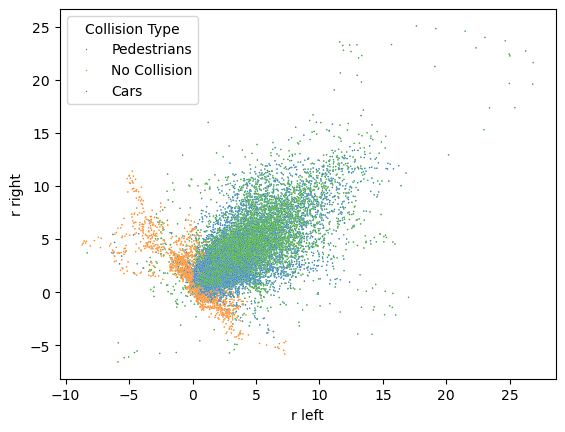

In [13]:
df_filt = df_responses[(df_responses["time"]>= -1000) & (df_responses["tile_idx_y"] == 1) & (df_responses["tile_idx_x"] == 1)]

sns.scatterplot(data=df_filt, x="r left", y="r right", hue="Collision Type", s=1)
plt.show()

In [12]:
df_responses.groupby(["coll_type"])["sample_id"].nunique()

coll_type
cars                  178
none                  116
none_with_crossing    120
none_with_traffic     112
pedestrians           173
Name: sample_id, dtype: int64

/tmp/ipykernel_1449295/149233535.py:255: RuntimeWarning: invalid value encountered in divide
  np.sqrt((_error_cars / _power_cars) ** 2 + (_error_none / _power_none) ** 2)
/tmp/ipykernel_1449295/149233535.py:261: RuntimeWarning: invalid value encountered in divide
  (_error_cars_linear / _power_cars_linear) ** 2
/tmp/ipykernel_1449295/149233535.py:255: RuntimeWarning: invalid value encountered in divide
  np.sqrt((_error_cars / _power_cars) ** 2 + (_error_none / _power_none) ** 2)
/tmp/ipykernel_1449295/149233535.py:261: RuntimeWarning: invalid value encountered in divide
  (_error_cars_linear / _power_cars_linear) ** 2
/tmp/ipykernel_1449295/149233535.py:255: RuntimeWarning: invalid value encountered in divide
  np.sqrt((_error_cars / _power_cars) ** 2 + (_error_none / _power_none) ** 2)
/tmp/ipykernel_1449295/149233535.py:261: RuntimeWarning: invalid value encountered in divide
  (_error_cars_linear / _power_cars_linear) ** 2
/tmp/ipykernel_1449295/149233535.py:381: SettingWithCopyWa

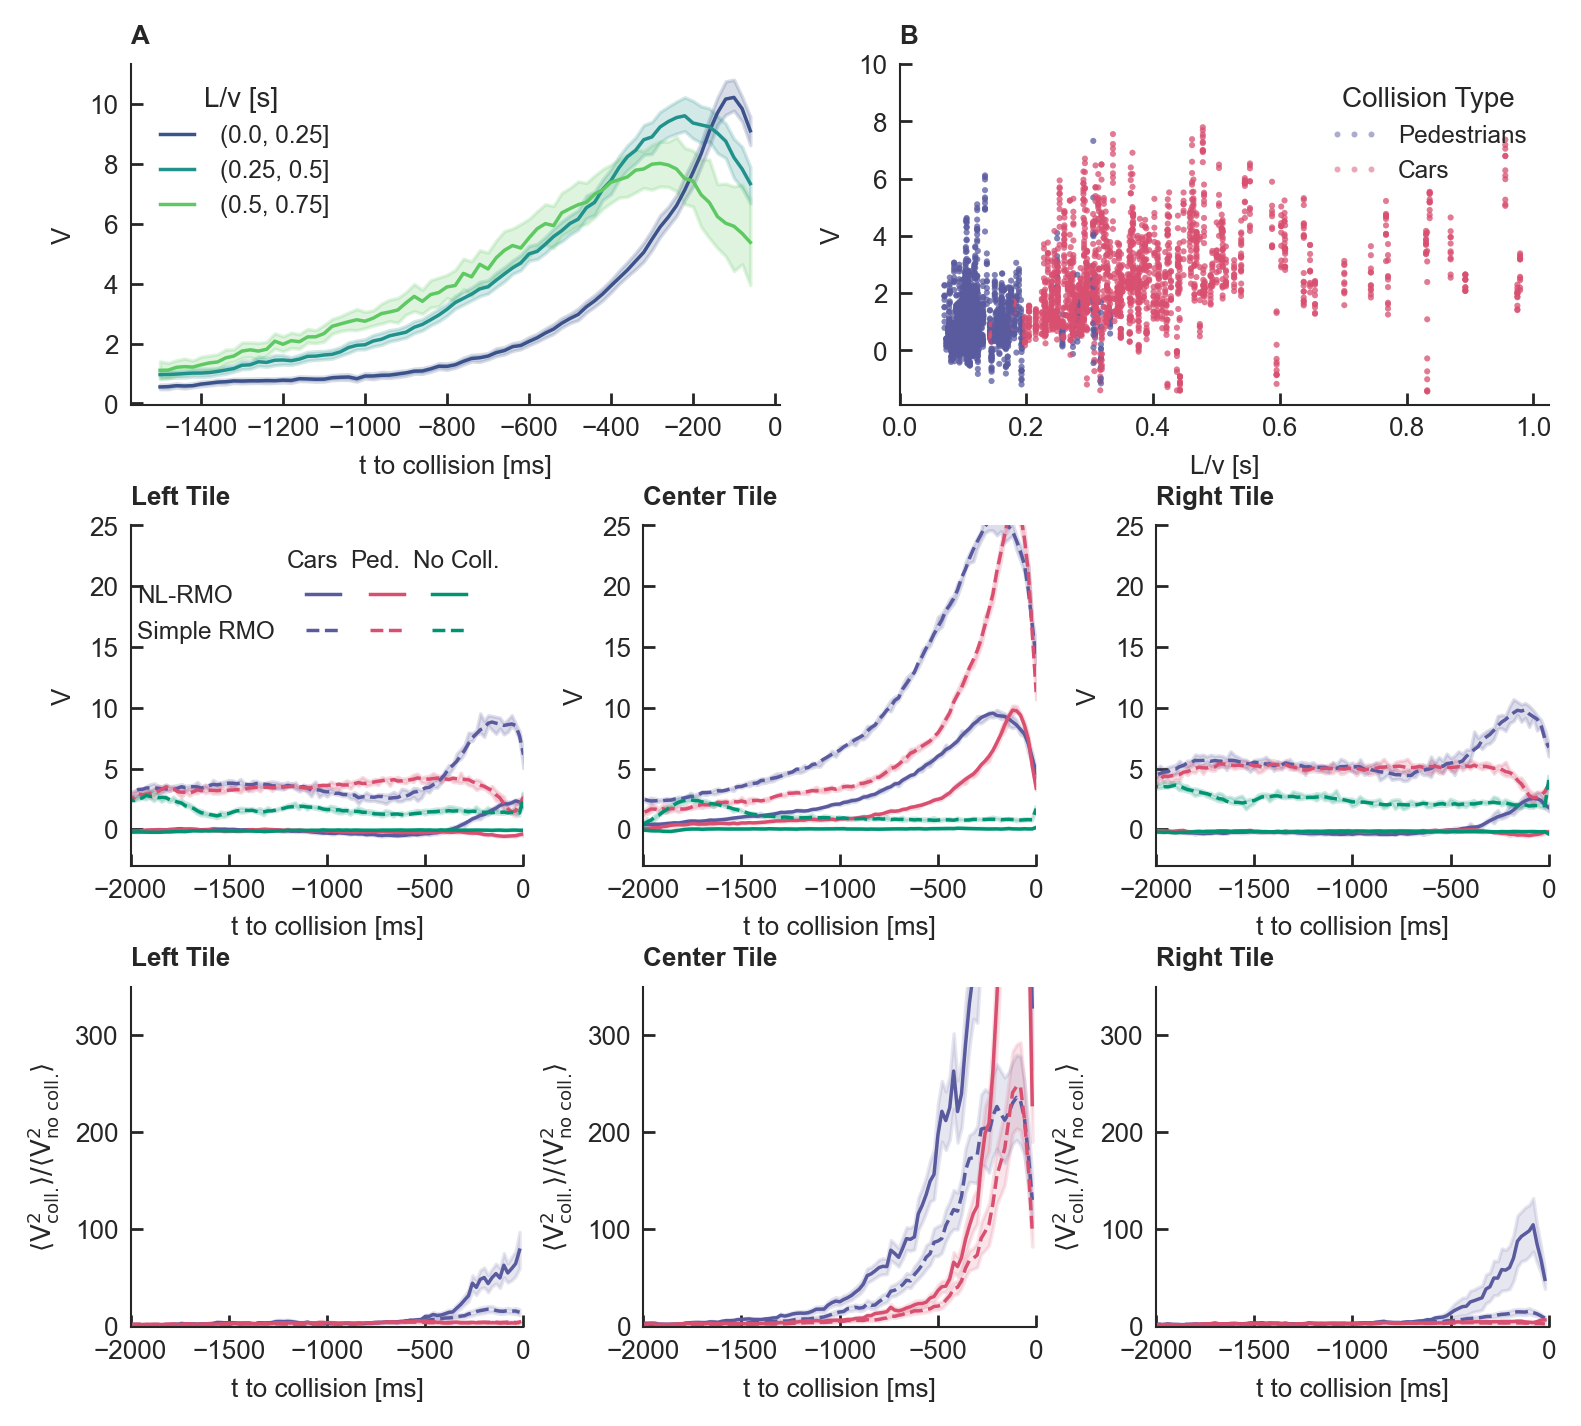

In [24]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "EMD")
]

plt.style.use('plots.mplstyle')

gs = plt.GridSpec(3, 6, width_ratios=[1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1])

fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH*0.9))

ax = [[],[]]
ax[0].append(fig.add_subplot(gs[1, :2]))
ax[0].append(fig.add_subplot(gs[1, 2:4]))
ax[0].append(fig.add_subplot(gs[1, 4:]))

ax[1].append(fig.add_subplot(gs[2, :2]))
ax[1].append(fig.add_subplot(gs[2, 2:4]))
ax[1].append(fig.add_subplot(gs[2, 4:]))

ax = np.array(ax)

#fig, ax = plt.subplots(2, 3, figsize=(TEXT_WIDTH, TEXT_WIDTH*0.6))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import matplotlib.patches as m_patches

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="NL-RMO"),
    m_patches.Patch(color="none", label="Simple RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]
patches_column4 = [m_patches.Patch(color="none", label="No Coll.")]

for k, _ax in enumerate(ax[0]):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]

    _o_cars = sns.lineplot(
        x="time",
        y="Output",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "Cars"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[0],
        label="*",
        legend=False,
    )

    _o_cars_linear = sns.lineplot(
        x="time",
        y="Output Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "Cars"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[0],
        linestyle="--",
        label="*",
        legend=False,
    )

    _o_pedestrians = sns.lineplot(
        x="time",
        y="Output",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "Pedestrians"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[1],
        label="*",
        legend=False,
    )

    _o_pedestrians_linear = sns.lineplot(
        x="time",
        y="Output Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "Pedestrians"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[1],
        linestyle="--",
        label="*",
        legend=False,
    )

    _o_none = sns.lineplot(
        x="time",
        y="Output",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "No Collision"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[2],
        label="*",
        legend=False,
    )

    _o_none_linear = sns.lineplot(
        x="time",
        y="Output Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "No Collision"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[2],
        linestyle="--",
        label="*",
        legend=False,
    )

    if k == 0:
        _lines = _ax.get_lines()
        patches_column2.extend([_lines[0], _lines[1]])
        patches_column3.extend([_lines[2], _lines[3]])
        patches_column4.extend([_lines[4], _lines[5]])

    _ax.set_ylabel("V")

    _ax.set_xlim(left=-2000, right=0.0)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=25.0, bottom=-3.0)

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)
patches.extend(patches_column4)

lg = ax[0, 0].legend(
    ncol=4,
    handles=patches,
    handletextpad=-2.5,
    borderpad=.5,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8, 10, 11):
        text.set_color("none")

alpha_sem = 0.15

for k, _ax in enumerate(ax[1]):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k)
        & (df_responses_filt["tile_idx_y"] == 1)
        & (df_responses_filt["time"] < 0.0)
    ].copy()

    _df_temp["Output Squ"] = _df_temp["Output"] * _df_temp["Output"]
    _df_temp["Output Linear Squ"] = (
        _df_temp["Output Linear"] * _df_temp["Output Linear"]
    )

    _power_resp = (
        _df_temp[["time", "Collision Type", "Output Squ", "Output Linear Squ"]]
        .groupby(["time", "Collision Type"])
        .mean()
        .reset_index()
    )
    _power_resp_sem = (
        _df_temp[["time", "Collision Type", "Output Squ", "Output Linear Squ"]]
        .groupby(["time", "Collision Type"])
        .sem()
        .reset_index()
    )

    _filt_cars = _power_resp["Collision Type"] == "Cars"
    _filt_pedestrians = _power_resp["Collision Type"] == "Pedestrians"
    _filt_none = _power_resp["Collision Type"] == "No Collision"

    _times_intersect = np.array(
        list(
            (
                set(_power_resp["time"][_filt_cars]).intersection(
                    set(_power_resp["time"][_filt_pedestrians])
                )
            ).intersection(set(_power_resp["time"][_filt_none]))
        )
    )

    _power_resp = _power_resp[_power_resp["time"].isin(_times_intersect)].copy()
    _power_resp_sem = _power_resp_sem[
        _power_resp_sem["time"].isin(_times_intersect)
    ].copy()

    _filt_cars = _power_resp["Collision Type"] == "Cars"
    _filt_pedestrians = _power_resp["Collision Type"] == "Pedestrians"
    _filt_none = _power_resp["Collision Type"] == "No Collision"

    _power_cars = np.array(list(_power_resp["Output Squ"][_filt_cars]))
    _power_cars_linear = np.array(list(_power_resp["Output Linear Squ"][_filt_cars]))
    _power_pedestrians = np.array(list(_power_resp["Output Squ"][_filt_pedestrians]))
    _power_pedestrians_linear = np.array(
        list(_power_resp["Output Linear Squ"][_filt_pedestrians])
    )
    _power_none = np.array(list(_power_resp["Output Squ"][_filt_none]))
    _power_none_linear = np.array(list(_power_resp["Output Linear Squ"][_filt_none]))

    _error_cars = np.array(list(_power_resp_sem["Output Squ"][_filt_cars]))
    _error_cars_linear = np.array(
        list(_power_resp_sem["Output Linear Squ"][_filt_cars])
    )
    _error_pedestrians = np.array(
        list(_power_resp_sem["Output Squ"][_filt_pedestrians])
    )
    _error_pedestrians_linear = np.array(
        list(_power_resp_sem["Output Linear Squ"][_filt_pedestrians])
    )
    _error_none = np.array(list(_power_resp_sem["Output Squ"][_filt_none]))
    _error_none_linear = np.array(
        list(_power_resp_sem["Output Linear Squ"][_filt_none])
    )

    _sign_to_noise_cars = _power_cars / _power_none
    _sign_to_noise_cars_linear = _power_cars_linear / _power_none_linear

    _sign_to_noise_pedestrians = _power_pedestrians / _power_none
    _sign_to_noise_pedestrians_linear = _power_pedestrians_linear / _power_none_linear

    # error propagation:
    # if A = B/C, then dA = sqrt((dB/B)^2 + (dC/C)^2) * A

    _error_sign_to_noise_cars = (
        np.sqrt((_error_cars / _power_cars) ** 2 + (_error_none / _power_none) ** 2)
        * _sign_to_noise_cars
    )

    _error_sign_to_noise_cars_linear = (
        np.sqrt(
            (_error_cars_linear / _power_cars_linear) ** 2
            + (_error_none_linear / _power_none_linear) ** 2
        )
        * _sign_to_noise_cars_linear
    )

    _error_sign_to_noise_pedestrians = (
        np.sqrt(
            (_error_pedestrians / _power_pedestrians) ** 2
            + (_error_none / _power_none) ** 2
        )
        * _sign_to_noise_pedestrians
    )

    _error_sign_to_noise_pedestrians_linear = (
        np.sqrt(
            (_error_pedestrians_linear / _power_pedestrians_linear) ** 2
            + (_error_none_linear / _power_none_linear) ** 2
        )
        * _sign_to_noise_pedestrians_linear
    )

    _times_intersect = np.sort(
        list(
            (
                set(_power_resp["time"][_filt_cars]).intersection(
                    set(_power_resp["time"][_filt_pedestrians])
                )
            ).intersection(set(_power_resp["time"][_filt_none]))
        )
    )

    _power_resp = _power_resp[_power_resp["time"].isin(_times_intersect)].copy()

    _filt_cars = _power_resp["Collision Type"] == "Cars"
    _filt_pedestrians = _power_resp["Collision Type"] == "Pedestrians"
    _filt_none = _power_resp["Collision Type"] == "No Collision"

    _ax.plot(_times_intersect, _sign_to_noise_cars, color=colors[0])
    _ax.fill_between(
        _times_intersect,
        _sign_to_noise_cars - _error_sign_to_noise_cars,
        _sign_to_noise_cars + _error_sign_to_noise_cars,
        color=colors[0],
        alpha=alpha_sem,
    )

    _ax.plot(
        _times_intersect, _sign_to_noise_cars_linear, color=colors[0], linestyle="--"
    )
    _ax.fill_between(
        _times_intersect,
        _sign_to_noise_cars_linear - _error_sign_to_noise_cars_linear,
        _sign_to_noise_cars_linear + _error_sign_to_noise_cars_linear,
        color=colors[0],
        alpha=alpha_sem,
    )

    _ax.plot(_times_intersect, _sign_to_noise_pedestrians, color=colors[1])
    _ax.fill_between(
        _times_intersect,
        _sign_to_noise_pedestrians - _error_sign_to_noise_pedestrians,
        _sign_to_noise_pedestrians + _error_sign_to_noise_pedestrians,
        color=colors[1],
        alpha=alpha_sem,
    )

    _ax.plot(
        _times_intersect,
        _sign_to_noise_pedestrians_linear,
        color=colors[1],
        linestyle="--",
    )
    _ax.fill_between(
        _times_intersect,
        _sign_to_noise_pedestrians_linear - _error_sign_to_noise_pedestrians_linear,
        _sign_to_noise_pedestrians_linear + _error_sign_to_noise_pedestrians_linear,
        color=colors[1],
        alpha=alpha_sem,
    )

    _ax.set_xlim(left=-2000, right=0.0)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=350.0, bottom=-1.0)

    _ax.set_ylabel(
        "$\\langle \\text{V}_{\\text{coll.}}^2\\rangle / \\langle \\text{V}_{\\text{no coll.}}^2\\rangle$"
    )

    # _ax.set_yscale("log")

ax[0, 0].set_title("Left Tile", loc="left")
ax[0, 1].set_title("Center Tile", loc="left")
ax[0, 2].set_title("Right Tile", loc="left")

ax[1, 0].set_title("Left Tile", loc="left")
ax[1, 1].set_title("Center Tile", loc="left")
ax[1, 2].set_title("Right Tile", loc="left")

#######################################

ax_lv_t = fig.add_subplot(gs[0, :3])
ax_lv_scatt = fig.add_subplot(gs[0, 3:])

df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3)
    & (df_responses["model"] == "EMD")
    & (df_responses["tile_idx_y"] == 1)
    & (df_responses["Collision Type"] != "No Collision")
].copy()

_df_temp = df_responses_filt[
    (df_responses_filt["tile_idx_x"] == 1)
    & (df_responses_filt["tile_idx_y"] == 1)
    & (df_responses_filt["L/v"] < 1.0)
    & (df_responses_filt.time >= -1500)
    & (df_responses_filt.time <= -50)
]

_df_temp["L/v [s]"] = _df_temp["L/v"]

sns.lineplot(
    x="time",
    y="Output",
    # estimator="mean",
    data=_df_temp,
    sort=True,
    orient="x",
    hue=pd.cut(
        _df_temp["L/v [s]"],
        bins=pd.IntervalIndex.from_tuples([(0.0, 0.25), (0.25, 0.5), (0.5, 0.75)]),
    ),
    palette="viridis",
    ax=ax_lv_t,
    n_boot=200,
)
# ax[0].set_xlim(left=-2000)
ax_lv_t.set_xlabel("t to collision [ms]")
ax_lv_t.set_ylabel("V")

sns.scatterplot(
    data=_df_temp[(_df_temp.time >= -1000) & (_df_temp.time <= -800)],
    # x=_df_temp["L/v"] * _df_temp["diameter"] / (-_df_temp["time"] * _df_temp["vel"]),
    x="L/v [s]",
    y="Output",
    # data=_df_temp[(_df_temp.time >= -750) & (_df_temp.time <= -250)],
    # sort=True,
    # orient="x",
    hue="Collision Type",
    # palette="viridis",
    ax=ax_lv_scatt,
    # n_boot=100,
    s=3,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)

ax_lv_scatt.set_ylabel("V")

ax_lv_scatt.set_ylim(top=10)
ax_lv_scatt.set_xlim(left=0.0)

ax_lv_t.set_title("A", loc="left")
ax_lv_scatt.set_title("B", loc="left")

fig.tight_layout(pad=0.25)

fig.savefig("responses_emd_3_tile.png", dpi=400)
fig.savefig("responses_emd_3_tile.pdf")

plt.show()

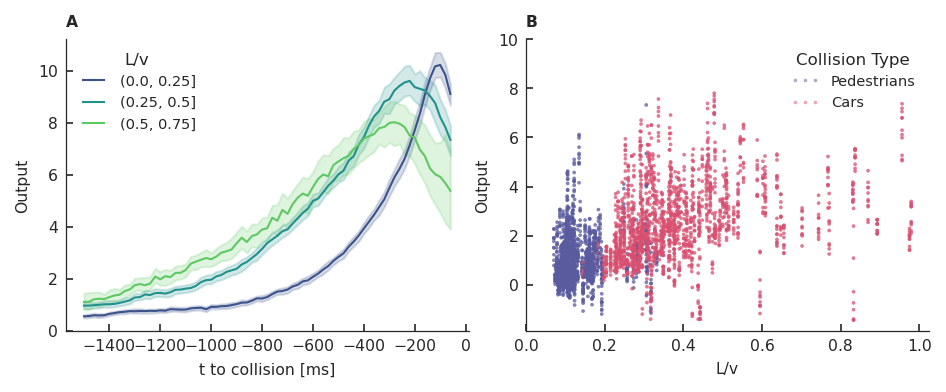

In [61]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3)
    & (df_responses["model"] == "EMD")
    & (df_responses["tile_idx_y"] == 1)
    & (df_responses["Collision Type"] != "No Collision")
]

fig, ax = plt.subplots(1, 2, figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.4))

_df_temp = df_responses_filt[
    (df_responses_filt["tile_idx_x"] == 1)
    & (df_responses_filt["tile_idx_y"] == 1)
    & (df_responses_filt["L/v"] < 1.0)
    & (df_responses_filt.time >= -1500)
    & (df_responses_filt.time <= -50)
]
sns.lineplot(
    x="time",
    y="Output",
    # estimator="mean",
    data=_df_temp,
    sort=True,
    orient="x",
    hue=pd.cut(
        _df_temp["L/v"],
        bins=pd.IntervalIndex.from_tuples([(0.0, 0.25), (0.25, 0.5), (0.5, 0.75)]),
    ),
    palette="viridis",
    ax=ax[0],
    n_boot=200,
)
# ax[0].set_xlim(left=-2000)
ax[0].set_xlabel("t to collision [ms]")

sns.scatterplot(
    data=_df_temp[(_df_temp.time >= -1000) & (_df_temp.time <= -800)],
    # x=_df_temp["L/v"] * _df_temp["diameter"] / (-_df_temp["time"] * _df_temp["vel"]),
    x="L/v",
    y="Output",
    # data=_df_temp[(_df_temp.time >= -750) & (_df_temp.time <= -250)],
    # sort=True,
    # orient="x",
    hue="Collision Type",
    # palette="viridis",
    ax=ax[1],
    # n_boot=100,
    s=3,
    linewidth=0,
    alpha=0.5,
)

ax[1].set_ylim(top=10)
ax[1].set_xlim(left=0.0)

ax[0].set_title("A", loc="left")
ax[1].set_title("B", loc="left")

fig.tight_layout(pad=0.25)

fig.savefig("l_v_responses_emd_3_tile.png", dpi=400)
fig.savefig("l_v_responses_emd_3_tile.pdf")

plt.show()

/tmp/ipykernel_396444/3871669426.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pr = pd.concat(


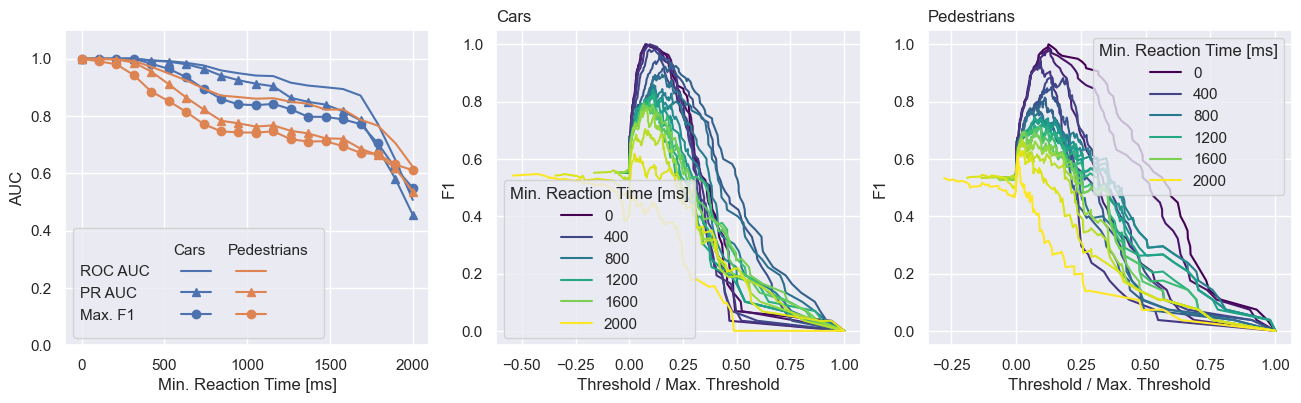

In [158]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    #& (df_responses["tile_idx_x"] == 1)
].copy()

df_emd["positive"] = df_emd["Collision Type"] != "No Collision"
#df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 20

min_react_time = np.linspace(0.0, 2000.0, n_sweep)

roc_car = []
roc_pedestrian = []
aupr_car = []
aupr_pedestrian = []

roc_curve_sweep_car = []
roc_curve_sweep_pedestrian = []

pr_curve_sweep_car = []
pr_curve_sweep_pedestrian = []

max_f1_car = []
max_f1_pedestrian = []

for t in min_react_time:
    _df_car = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] >= -2000.)) & (df_emd["Collision Type"] != "Pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] >= -2000.)) & (df_emd["Collision Type"] != "Cars")
    ].copy()

    df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car.append(roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"]))
    aupr_car.append(average_precision_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"]))
    roc_curve_sweep_car.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"])
    )

    roc_pedestrian.append(roc_auc_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]))
    aupr_pedestrian.append(average_precision_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]))
    roc_curve_sweep_pedestrian.append(
        roc_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"])
    )

    pr_curve_sweep_car.append(
        precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"])
    )
    pr_curve_sweep_pedestrian.append(
        precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"])
    )

    num = 2 * pr_curve_sweep_car[-1][0] * pr_curve_sweep_car[-1][1]
    denom = pr_curve_sweep_car[-1][0] + pr_curve_sweep_car[-1][1]
    max_f1_car.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0)).max()

    )
    num = 2 * pr_curve_sweep_pedestrian[-1][0] * pr_curve_sweep_pedestrian[-1][1]
    denom = pr_curve_sweep_pedestrian[-1][0] + pr_curve_sweep_pedestrian[-1][1]
    max_f1_pedestrian.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0)).max()
    )

import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="ROC AUC"),
    m_patches.Patch(color="none", label="PR AUC"),
    m_patches.Patch(color="none", label="Max. F1"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_aupr = ax[0].plot(min_react_time, aupr_car, "-^", c=colors[0], label="*")
c_max_f1 = ax[0].plot(min_react_time, max_f1_car, "-o", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_aupr[0], c_max_f1[0]])
p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_aupr = ax[0].plot(min_react_time, aupr_pedestrian, "-^", c=colors[1], label="*")
p_max_f1 = ax[0].plot(min_react_time, max_f1_pedestrian, "-o", c=colors[1], label="*")
patches_column3.extend([p_roc[0], p_aupr[0], p_max_f1[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("AUC")
ax[0].set_xlabel("Min. Reaction Time [ms]")
lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (5, 6, 7, 9, 10, 11):
        text.set_color("none")

cmap = plt.get_cmap("viridis")

df_pr = pd.DataFrame(columns=["recall", "precision", "model", "Min. Reaction Time [ms]", "Collision Type", "F1", "Threshold / Max. Threshold"])
for i, pr in enumerate(pr_curve_sweep_car):
    num = 2 * pr[0] * pr[1]
    denom = pr[0] + pr[1]
    f1 = np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0))
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "Collision Type": "Cars",
                    "F1": f1[1:],
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

for i, pr in enumerate(pr_curve_sweep_pedestrian):
    num = 2 * pr[0] * pr[1]
    denom = pr[0] + pr[1]
    f1 = np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0))
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "Collision Type": "Pedestrians",
                    "F1": f1[1:],
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr["Collision Type"]=="Cars"], ax=ax[1], hue="Min. Reaction Time [ms]", palette="viridis")

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr["Collision Type"]=="Pedestrians"], ax=ax[2], hue="Min. Reaction Time [ms]", palette="viridis") 

ax[1].set_title("Cars", loc="left")
ax[2].set_title("Pedestrians", loc="left")

#ax[1].set_xlim(right=0.2)

fig.tight_layout(pad=0.5)
fig.savefig("roc_pr_emd.png", dpi=400)
fig.savefig("roc_pr_emd.pdf")
plt.show()

/tmp/ipykernel_396444/196083794.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pr = pd.concat(


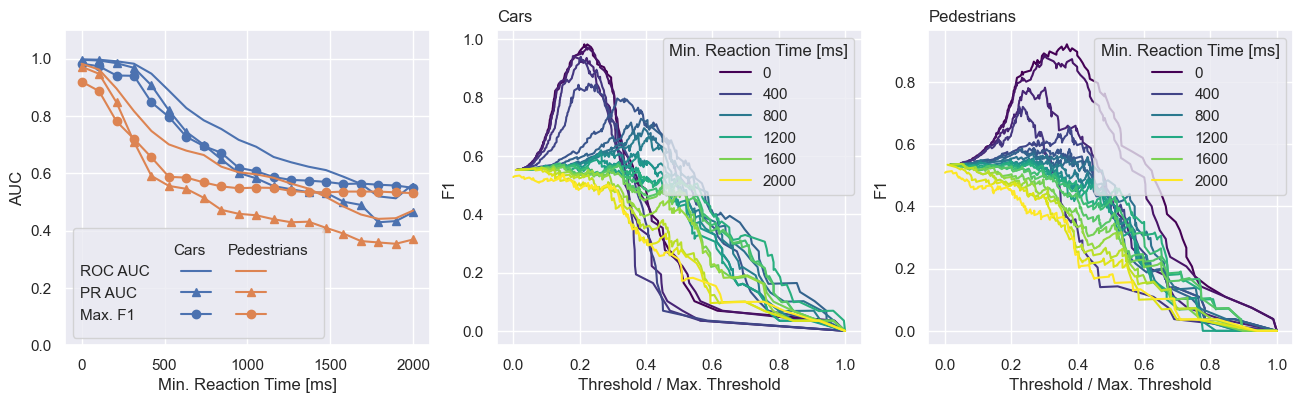

In [159]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    #& (df_responses["tile_idx_x"] == 1)
].copy()

df_emd["positive"] = df_emd["Collision Type"] != "No Collision"
#df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 20

min_react_time = np.linspace(0.0, 2000.0, n_sweep)

roc_car = []
roc_pedestrian = []
aupr_car = []
aupr_pedestrian = []

roc_curve_sweep_car = []
roc_curve_sweep_pedestrian = []

pr_curve_sweep_car = []
pr_curve_sweep_pedestrian = []

max_f1_car = []
max_f1_pedestrian = []

for t in min_react_time:
    _df_car = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] >= -2000.)) & (df_emd["Collision Type"] != "Pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] >= -2000.)) & (df_emd["Collision Type"] != "Cars")
    ].copy()

    df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car.append(roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"]))
    aupr_car.append(average_precision_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"]))
    roc_curve_sweep_car.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"])
    )

    roc_pedestrian.append(roc_auc_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Linear"]))
    aupr_pedestrian.append(average_precision_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Linear"]))
    roc_curve_sweep_pedestrian.append(
        roc_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Linear"])
    )

    pr_curve_sweep_car.append(
        precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"])
    )
    pr_curve_sweep_pedestrian.append(
        precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Linear"])
    )

    num = 2 * pr_curve_sweep_car[-1][0] * pr_curve_sweep_car[-1][1]
    denom = pr_curve_sweep_car[-1][0] + pr_curve_sweep_car[-1][1]
    max_f1_car.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0)).max()

    )
    num = 2 * pr_curve_sweep_pedestrian[-1][0] * pr_curve_sweep_pedestrian[-1][1]
    denom = pr_curve_sweep_pedestrian[-1][0] + pr_curve_sweep_pedestrian[-1][1]
    max_f1_pedestrian.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0)).max()
    )

import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="ROC AUC"),
    m_patches.Patch(color="none", label="PR AUC"),
    m_patches.Patch(color="none", label="Max. F1"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_aupr = ax[0].plot(min_react_time, aupr_car, "-^", c=colors[0], label="*")
c_max_f1 = ax[0].plot(min_react_time, max_f1_car, "-o", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_aupr[0], c_max_f1[0]])
p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_aupr = ax[0].plot(min_react_time, aupr_pedestrian, "-^", c=colors[1], label="*")
p_max_f1 = ax[0].plot(min_react_time, max_f1_pedestrian, "-o", c=colors[1], label="*")
patches_column3.extend([p_roc[0], p_aupr[0], p_max_f1[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("AUC")
ax[0].set_xlabel("Min. Reaction Time [ms]")
lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (5, 6, 7, 9, 10, 11):
        text.set_color("none")

cmap = plt.get_cmap("viridis")

df_pr = pd.DataFrame(columns=["recall", "precision", "model", "Min. Reaction Time [ms]", "Collision Type", "F1", "Threshold / Max. Threshold"])
for i, pr in enumerate(pr_curve_sweep_car):
    num = 2 * pr[0] * pr[1]
    denom = pr[0] + pr[1]
    f1 = np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0))
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "Collision Type": "Cars",
                    "F1": f1[1:],
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

for i, pr in enumerate(pr_curve_sweep_pedestrian):
    num = 2 * pr[0] * pr[1]
    denom = pr[0] + pr[1]
    f1 = np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0))
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "Collision Type": "Pedestrians",
                    "F1": f1[1:],
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr["Collision Type"]=="Cars"], ax=ax[1], hue="Min. Reaction Time [ms]", palette="viridis")

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr["Collision Type"]=="Pedestrians"], ax=ax[2], hue="Min. Reaction Time [ms]", palette="viridis") 

ax[1].set_title("Cars", loc="left")
ax[2].set_title("Pedestrians", loc="left")

#ax[1].set_xlim(right=0.2)

fig.tight_layout(pad=0.5)
fig.savefig("roc_pr_emd_linear.png", dpi=400)
fig.savefig("roc_pr_emd_linear.pdf")
plt.show()

### Functions to Calculate Performance Metrics with Safety Margins

In [7]:
def calc_min_react_time_sweep(df, n_sweep, t_max, t_window, n_samples=10):
    roc = {
        "RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},
    }
    aupr = {
        "RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},
    }
    roc_curve_sweep = {
        "RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},
    }
    pr_curve_sweep = {
        "RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},
    }
    max_f1 = {
        "RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},
    }

    df = df.copy()
    df["positive"] = df["Collision Type"] != "No Collision"

    min_reaction_time = np.linspace(0.0, t_max - t_window, n_sweep)

    for rmo in ["RMO", "No RMO"]:
        for obj in ["Cars", "Pedestrians"]:
            print(f"Calculating {rmo} {obj}...")
            for i in range(n_samples):
                print(f"Sample {i+1}/{n_samples}", end="\r")

                roc[rmo][obj].append([])
                aupr[rmo][obj].append([])
                roc_curve_sweep[rmo][obj].append([])
                pr_curve_sweep[rmo][obj].append([])
                max_f1[rmo][obj].append([])

                for t in min_reaction_time:
                    t_no_coll_t0 = np.random.rand() * (t_max - t_window)
                    _df_filt = df[
                        (
                            (
                                (df["time"] <= -t)
                                & (df["time"] >= -(t + t_window))
                            )
                            & (df["Collision Type"] == obj)
                        )
                        | (
                            (
                                (df["time"] <= -t_no_coll_t0)
                                & (df["time"] >= -(t_no_coll_t0 + t_window))
                            )
                            & (df["Collision Type"] == "No Collision")
                        )
                    ].copy()

                    df_max_resp = (
                        _df_filt.groupby(["sample_id", "positive"]).max().reset_index()
                    )

                    min_class_samples = df_max_resp["positive"].value_counts().min()
                    df_max_resp = (
                        df_max_resp.groupby("positive", as_index=False)[
                            [
                                "positive",
                                "Output" if (rmo == "RMO") else "Output Linear",
                            ]
                        ]
                        .apply(lambda x: x.sample(n=min_class_samples))
                        .reset_index(drop=True)
                    )

                    if rmo == "No RMO":
                        df_max_resp["Output"] = df_max_resp["Output Linear"]

                    roc[rmo][obj][-1].append(
                        roc_auc_score(df_max_resp["positive"], df_max_resp["Output"])
                    )
                    aupr[rmo][obj][-1].append(
                        average_precision_score(
                            df_max_resp["positive"], df_max_resp["Output"]
                        )
                    )
                    roc_curve_sweep[rmo][obj][-1].append(
                        roc_curve(df_max_resp["positive"], df_max_resp["Output"])
                    )

                    pr_curve_sweep[rmo][obj][-1].append(
                        precision_recall_curve(
                            df_max_resp["positive"], df_max_resp["Output"]
                        )
                    )

                    num = 2 * pr_curve_sweep[rmo][obj][-1][-1][0] * pr_curve_sweep[rmo][obj][-1][-1][1]
                    denom = pr_curve_sweep[rmo][obj][-1][-1][0] + pr_curve_sweep[rmo][obj][-1][-1][1]
                    max_f1[rmo][obj][-1].append(
                        np.divide(num, denom, out=np.zeros_like(denom), where=(denom != 0)).max()
                    )
            
            roc[rmo][obj] = np.array(roc[rmo][obj])
            aupr[rmo][obj] = np.array(aupr[rmo][obj])
            #roc_curve_sweep[rmo][obj] = np.array(roc_curve_sweep[rmo][obj])
            #pr_curve_sweep[rmo][obj] = np.array(pr_curve_sweep[rmo][obj])
            max_f1[rmo][obj] = np.array(max_f1[rmo][obj])
    
    return min_reaction_time, roc, aupr, roc_curve_sweep, pr_curve_sweep, max_f1

In [8]:
def calc_min_velocity_sweep(
    df,
    n_sweep,
    vel_min_kmh,
    vel_max_kmh,
    a_break_mpssq,
    t_max=2000.0,
    t_window=200.0,
    n_samples=10,
):
    roc = {
        "RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},
    }
    aupr = {
        "RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},
    }
    roc_curve_sweep = {
        "RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},
    }
    pr_curve_sweep = {
        "RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},
    }
    max_f1 = {
        "RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},
    }

    df = df.copy()
    df["positive"] = df["Collision Type"] != "No Collision"

    df["min_stop_dist"] = df["vel"] ** 2 / (2 * a_break_mpssq)
    df["min_stop_time"] = (df["vel"] / (2 * a_break_mpssq)) * 1000.0

    vel = np.linspace(vel_min_kmh / 3.6, vel_max_kmh / 3.6, n_sweep + 1)

    for rmo in ["RMO", "No RMO"]:
        for obj in ["Cars", "Pedestrians"]:
            print(f"Calculating {rmo} {obj}...")
            for i in range(n_samples):
                print(f"Sample {i+1}/{n_samples}", end="\r")
                roc[rmo][obj].append([])
                aupr[rmo][obj].append([])
                roc_curve_sweep[rmo][obj].append([])
                pr_curve_sweep[rmo][obj].append([])
                max_f1[rmo][obj].append([])

                for j in range(len(vel) - 1):
                    v0 = vel[j]
                    v1 = vel[j + 1]

                    t_no_coll_t0 = np.random.rand() * (t_max - t_window)
                    _df_filt = df[
                        (
                            ((df["vel"] >= v0) & (df["vel"] < v1))
                            & (
                                (df["time"] <= -df["min_stop_time"])
                                & (df["time"] >= -(df["min_stop_time"] + t_window))
                            )
                            &
                            (df["Collision Type"] == obj)
                        )
                        | (
                            (
                                (df["time"] <= -t_no_coll_t0)
                                & (df["time"] >= -(t_no_coll_t0 + t_window))
                            )
                            & (df["Collision Type"] == "No Collision")
                        )
                    ].copy()

                    df_max_resp = (
                        _df_filt.groupby(["sample_id", "positive"]).max().reset_index()
                    )

                    min_class_samples = df_max_resp["positive"].value_counts().min()
                    df_max_resp = (
                        df_max_resp.groupby("positive", as_index=False)[
                            [
                                "positive",
                                "Output" if (rmo == "RMO") else "Output Linear",
                            ]
                        ]
                        .apply(lambda x: x.sample(n=min_class_samples))
                        .reset_index(drop=True)
                    )

                    if rmo == "No RMO":
                        df_max_resp["Output"] = df_max_resp["Output Linear"]

                    roc[rmo][obj][-1].append(
                        roc_auc_score(df_max_resp["positive"], df_max_resp["Output"])
                    )
                    aupr[rmo][obj][-1].append(
                        average_precision_score(
                            df_max_resp["positive"], df_max_resp["Output"]
                        )
                    )
                    roc_curve_sweep[rmo][obj][-1].append(
                        roc_curve(df_max_resp["positive"], df_max_resp["Output"])
                    )

                    pr_curve_sweep[rmo][obj][-1].append(
                        precision_recall_curve(
                            df_max_resp["positive"], df_max_resp["Output"]
                        )
                    )

                    num = (
                        2
                        * pr_curve_sweep[rmo][obj][-1][-1][0]
                        * pr_curve_sweep[rmo][obj][-1][-1][1]
                    )
                    denom = (
                        pr_curve_sweep[rmo][obj][-1][-1][0]
                        + pr_curve_sweep[rmo][obj][-1][-1][1]
                    )
                    max_f1[rmo][obj][-1].append(
                        np.divide(
                            num, denom, out=np.zeros_like(denom), where=(denom != 0)
                        ).max()
                    )

            roc[rmo][obj] = np.array(roc[rmo][obj])
            aupr[rmo][obj] = np.array(aupr[rmo][obj])
            # roc_curve_sweep[rmo][obj] = np.array(roc_curve_sweep[rmo][obj])
            # pr_curve_sweep[rmo][obj] = np.array(pr_curve_sweep[rmo][obj])
            max_f1[rmo][obj] = np.array(max_f1[rmo][obj])

    return (
        vel,
        roc,
        aupr,
        roc_curve_sweep,
        pr_curve_sweep,
        max_f1,
    )

In [9]:
min_reaction_time, roc, aupr, roc_curve_sweep, pr_curve_sweep, max_f1 = (
    calc_min_react_time_sweep(
        df_responses[
            (df_responses["model"] == "EMD")
            & (df_responses["n tiles"] == 3)
            & (df_responses["tile_idx_y"] == 1)
        ],
        20,
        2000,
        200,
        50,
    )
)

Calculating RMO Cars...
Calculating RMO Pedestrians...
Calculating No RMO Cars...
Calculating No RMO Pedestrians...


In [10]:
A_BREAK = 7.5

vel, roc_vel, aupr_vel, roc_curve_sweep_vel, pr_curve_sweep_vel, max_f1_vel = calc_min_velocity_sweep(
    df_responses[
        (df_responses["model"] == "EMD")
        & (df_responses["n tiles"] == 3)
        & (df_responses["tile_idx_y"] == 1)
    ],
    3,
    10.0,
    40.0,
    A_BREAK,
    t_max=2000.0,
    t_window=200.0,
    n_samples=50,
)

Calculating RMO Cars...
Calculating RMO Pedestrians...
Calculating No RMO Cars...
Calculating No RMO Pedestrians...


In [11]:
df_vel_roc = pd.DataFrame(columns=["vel", "roc", "roc_sem", "model", "Collision Type"])

for i, v in enumerate(vel[:-1]):
    for rmo in ["RMO", "No RMO"]:
        for obj in ["Cars", "Pedestrians"]:
            df_vel_roc = pd.concat(
                [
                    df_vel_roc,
                    pd.DataFrame(
                        {
                            "vel": v * 3.6,
                            "roc": roc_vel[rmo][obj][:, i].mean(),
                            "roc_sem": roc_vel[rmo][obj][:, i].std(),
                            "model": rmo,
                            "Collision Type": obj,
                        },
                        index=[0],
                    ),
                ],
                ignore_index=True,
            )

/tmp/ipykernel_1629680/1150748698.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_vel_roc = pd.concat(


In [12]:
df_vel_roc

,vel,roc,roc_sem,model,Collision Type
0,10.0,0.995605,0.002329,RMO,Cars
1,10.0,0.982927,0.005600,RMO,Pedestrians
2,10.0,0.980449,0.010249,No RMO,Cars
3,10.0,0.921166,0.029370,No RMO,Pedestrians
4,20.0,0.994145,0.001737,RMO,Cars
5,20.0,0.966122,0.011218,RMO,Pedestrians
6,20.0,0.972892,0.011932,No RMO,Cars
7,20.0,0.808583,0.077041,No RMO,Pedestrians
8,30.0,0.987307,0.007202,RMO,Cars
9,30.0,0.897461,0.033582,RMO,Pedestrians


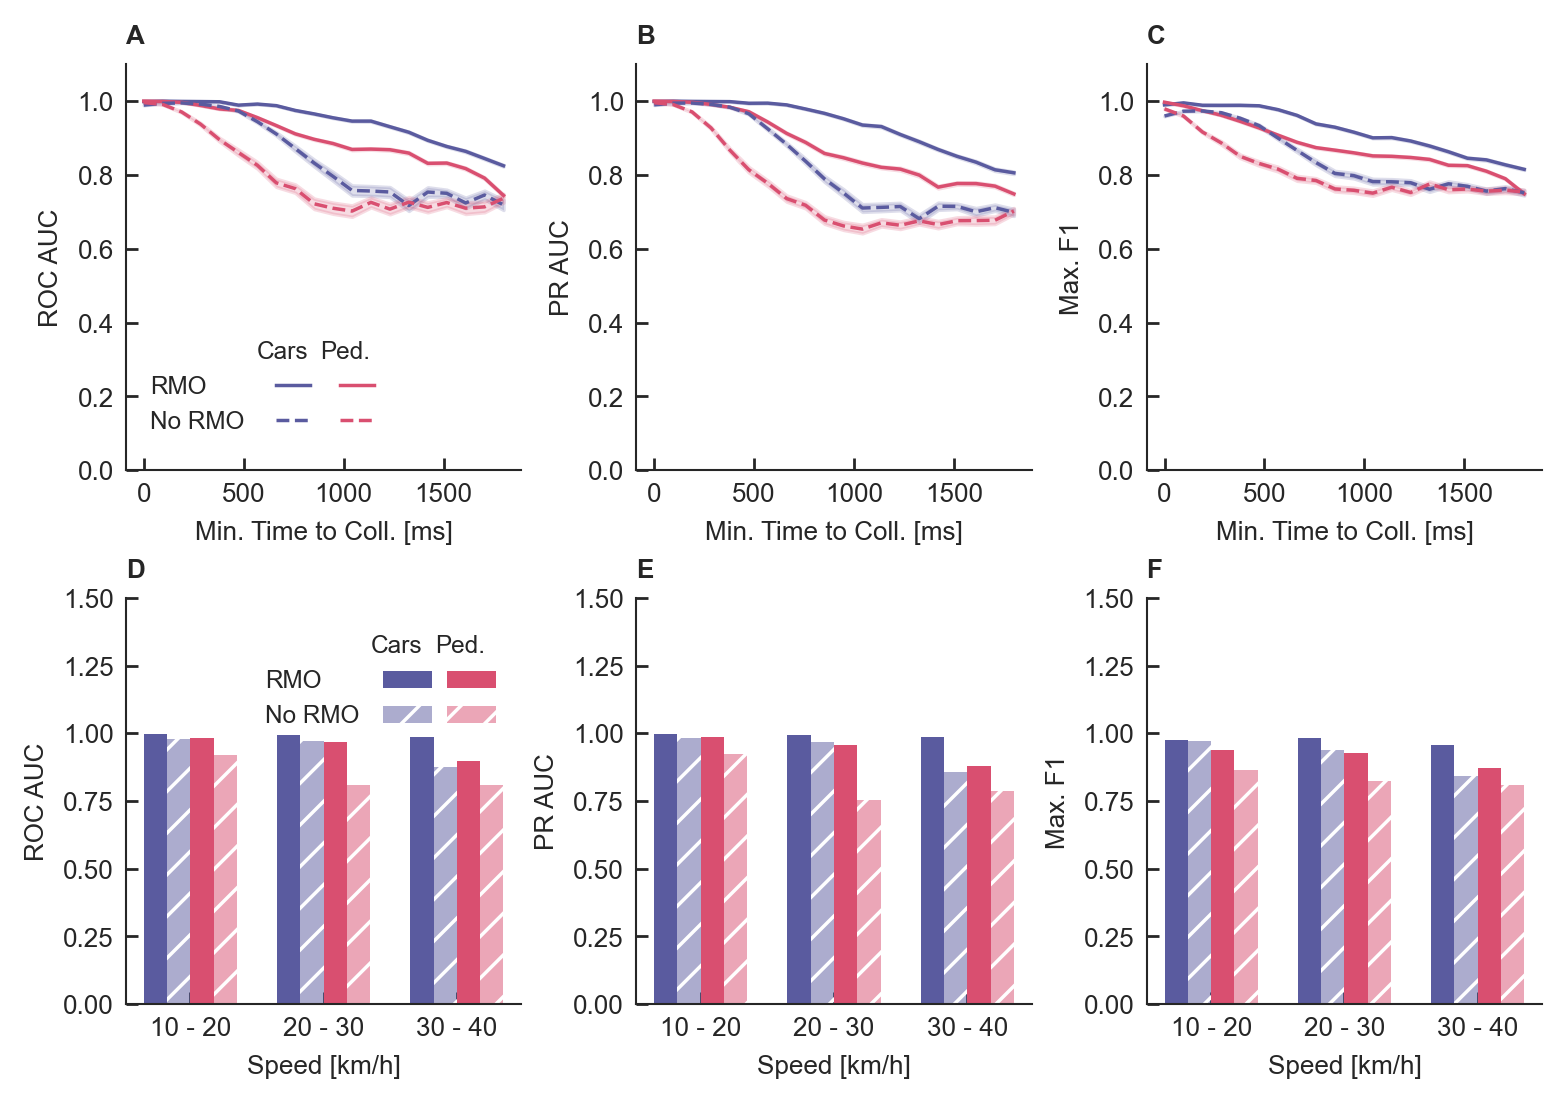

In [13]:
import matplotlib.patches as m_patches



patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]

plt.style.use('plots.mplstyle')

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(2, 3, figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.7))

ptch = [patches_column2, patches_column3]

for i, rmo in enumerate(["RMO", "No RMO"]):
    for j, obj in enumerate(["Cars", "Pedestrians"]):
        lnstyle = ["-", "--"][i]
        color = colors[j]

        (_roc,) = ax[0,0].plot(
            min_reaction_time,
            roc[rmo][obj].mean(axis=0),
            lnstyle,
            c=color,
            label="*",
        )

        ptch[j].append(_roc)

        ax[0,1].plot(
            min_reaction_time, aupr[rmo][obj].mean(axis=0), lnstyle, c=color, label="*"
        )

        ax[0,2].plot(
            min_reaction_time, max_f1[rmo][obj].mean(axis=0), lnstyle, c=color, label="*"
        )

        for k, metric in enumerate([roc, aupr, max_f1]):
            ax[0,k].fill_between(
                min_reaction_time,
                metric[rmo][obj].mean(axis=0)
                - metric[rmo][obj].std(axis=0) / np.sqrt(1 + metric[rmo][obj].shape[0]),
                metric[rmo][obj].mean(axis=0)
                + metric[rmo][obj].std(axis=0) / np.sqrt(1 + metric[rmo][obj].shape[0]),
                alpha=0.2,
                color=color,
            )


patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

lg = ax[0,0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, letter in enumerate(["A", "B", "C"]):
    ax[0,i].set_ylim(top=1.1, bottom=0.0)
    ax[0,i].set_xlabel("Min. Time to Coll. [ms]")
    ax[0,i].set_title(letter, loc="left", fontweight="bold")

ax[0,0].set_ylabel("ROC AUC")
ax[0,1].set_ylabel("PR AUC")
ax[0,2].set_ylabel("Max. F1")

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")

#####################################################

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]

vel_ax = 0.5 * (vel[:-1] + vel[1:]) * 3.6

d_vel = (vel[1:] - vel[:-1]) * 3.6
perc_width = 0.7

ptch = [patches_column2, patches_column3]

for i, rmo in enumerate(["RMO", "No RMO"]):
    for j, obj in enumerate(["Cars", "Pedestrians"]):
        hatchstyle = [None, "//"][i]
        alpha = [1.0, 0.5][i]
        color = colors[j]

        barcontainer = ax[1,0].bar(
            vel_ax + (0.5 * i + j - 0.75) * d_vel * perc_width / 2,
            roc_vel[rmo][obj].mean(axis=0),
            d_vel * perc_width / 4,
            color=colors[j],
            label="*",
            hatch=hatchstyle,
            linewidth=0.5,
            alpha=alpha,
        )

        for bc in barcontainer:
            bc._hatch_color = (1, 1, 1)
            bc.stale = True

        ptch[j].append(barcontainer)

        barcontainer = ax[1,1].bar(
            vel_ax + (0.5 * i + j - 0.75) * d_vel * perc_width / 2,
            aupr_vel[rmo][obj].mean(axis=0),
            d_vel * perc_width / 4,
            color=colors[j],
            label="*",
            hatch=hatchstyle,
            linewidth=0.5,
            alpha=alpha,
        )

        for bc in barcontainer:
            bc._hatch_color = (1, 1, 1)
            bc.stale = True

        barcontainer = ax[1,2].bar(
            vel_ax + (0.5 * i + j - 0.75) * d_vel * perc_width / 2,
            max_f1_vel[rmo][obj].mean(axis=0),
            d_vel * perc_width / 4,
            color=colors[j],
            label="*",
            hatch=hatchstyle,
            linewidth=0.5,
            alpha=alpha,
        )

        for bc in barcontainer:
            bc._hatch_color = (1, 1, 1)
            bc.stale = True

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

xticks = [f"{vel[i]*3.6:.0f} - {vel[i+1]*3.6:.0f}" for i in range(len(vel) - 1)]

for i, letter in enumerate(["D", "E", "F"]):
    ax[1,i].set_ylim(top=1.5, bottom=0.0)
    ax[1,i].set_xticks(vel_ax, xticks)
    ax[1,i].set_xlabel("Speed [km/h]")
    ax[1,i].set_title(letter, loc="left", fontweight="bold")

ax[1,0].set_ylabel("ROC AUC")
ax[1,1].set_ylabel("PR AUC")
ax[1,2].set_ylabel("Max. F1")


lg = ax[1,0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")


fig.tight_layout(pad=0.5)
fig.savefig("score_comp_emd_ttc_speed.png", dpi=400)
fig.savefig("score_comp_emd_ttc_speed.pdf")
plt.show()

In [31]:
ind_t = 14

min_reaction_time[ind_t]

1326.3157894736844

In [77]:
roc_df = pd.DataFrame(
    {
        "RMO": {
            "Cars": roc["RMO"]["Cars"].mean(axis=0)[ind_t],
            "Pedestrians": roc["RMO"]["Pedestrians"].mean(axis=0)[ind_t],
        },
        "RMO Error": {
            "Cars": roc["RMO"]["Cars"].std(axis=0)[ind_t] / np.sqrt(1 + roc["RMO"]["Cars"].shape[0]),
            "Pedestrians": roc["RMO"]["Pedestrians"].std(axis=0)[ind_t] / np.sqrt(1 + roc["RMO"]["Pedestrians"].shape[0]),
        },
        "No RMO": {
            "Cars": roc["No RMO"]["Cars"].mean(axis=0)[ind_t],
            "Pedestrians": roc["No RMO"]["Pedestrians"].mean(axis=0)[ind_t],
        },
        "No RMO Error": {
            "Cars": roc["No RMO"]["Cars"].std(axis=0)[ind_t] / np.sqrt(1 + roc["No RMO"]["Cars"].shape[0]),
            "Pedestrians": roc["No RMO"]["Pedestrians"].std(axis=0)[ind_t] / np.sqrt(1 + roc["No RMO"]["Pedestrians"].shape[0]),
        },
    }
)

print(roc_df)
print(f"\nReaction Time: {min_reaction_time[ind_t]} ms")

                  RMO  RMO Error    No RMO  No RMO Error
Cars         0.912722   0.001606  0.741394      0.013161
Pedestrians  0.856411   0.002441  0.720593      0.013188

Reaction Time: 1326.3157894736844 ms


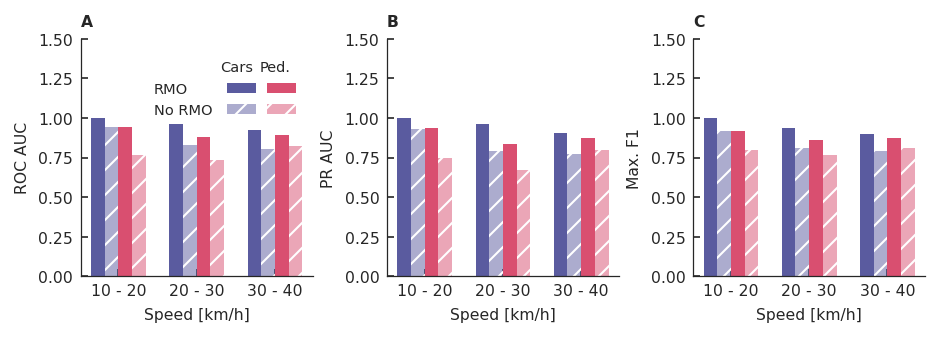

Assumed deceleration: 7.5 m/s^2


In [40]:
import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]

plt.style.use("plots.mplstyle")
fig, ax = plt.subplots(1, 3, figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.35))

vel_ax = 0.5 * (vel[:-1] + vel[1:]) * 3.6

d_vel = (vel[1:] - vel[:-1]) * 3.6
perc_width = 0.7


ptch = [patches_column2, patches_column3]

for i, rmo in enumerate(["RMO", "No RMO"]):
    for j, obj in enumerate(["Cars", "Pedestrians"]):
        hatchstyle = [None, "//"][i]
        alpha = [1.0, 0.5][i]
        color = colors[j]

        barcontainer = ax[0].bar(
            vel_ax + (0.5 * i + j - 0.75) * d_vel * perc_width / 2,
            roc_vel[rmo][obj].mean(axis=0),
            d_vel * perc_width / 4,
            color=colors[j],
            label="*",
            hatch=hatchstyle,
            linewidth=0.5,
            alpha=alpha,
        )

        for bc in barcontainer:
            bc._hatch_color = (1, 1, 1)
            bc.stale = True

        ptch[j].append(barcontainer)

        barcontainer = ax[1].bar(
            vel_ax + (0.5 * i + j - 0.75) * d_vel * perc_width / 2,
            aupr_vel[rmo][obj].mean(axis=0),
            d_vel * perc_width / 4,
            color=colors[j],
            label="*",
            hatch=hatchstyle,
            linewidth=0.5,
            alpha=alpha,
        )

        for bc in barcontainer:
            bc._hatch_color = (1, 1, 1)
            bc.stale = True

        barcontainer = ax[2].bar(
            vel_ax + (0.5 * i + j - 0.75) * d_vel * perc_width / 2,
            max_f1_vel[rmo][obj].mean(axis=0),
            d_vel * perc_width / 4,
            color=colors[j],
            label="*",
            hatch=hatchstyle,
            linewidth=0.5,
            alpha=alpha,
        )

        for bc in barcontainer:
            bc._hatch_color = (1, 1, 1)
            bc.stale = True

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

xticks = [f"{vel[i]*3.6:.0f} - {vel[i+1]*3.6:.0f}" for i in range(len(vel) - 1)]

for i, letter in enumerate(["A", "B", "C"]):
    ax[i].set_ylim(top=1.5, bottom=0.0)
    ax[i].set_xticks(vel_ax, xticks)
    ax[i].set_xlabel("Speed [km/h]")
    ax[i].set_title(letter, loc="left", fontweight="bold")

ax[0].set_ylabel("ROC AUC")
ax[1].set_ylabel("PR AUC")
ax[2].set_ylabel("Max. F1")


lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")

fig.tight_layout(pad=0.5)
fig.savefig("score_comp_emd_speeds.png", dpi=400)
fig.savefig("score_comp_emd_speeds.pdf")
plt.show()

print(f"Assumed deceleration: {A_BREAK} m/s^2")

The above figure shows the performance measures for different driving speeds under the condition that the detection should be before the minimal stopping distance for the given speed.

Under constant deceleration $a$, the minimum stopping distance is $d = v^2 / (2 a)$.

Some references for deceleration values:

+ https://www.sae.org/publications/technical-papers/content/2023-01-0616/
+ https://www.tandfonline.com/doi/pdf/10.1080/16484142.2007.9638118

### Calculate Mean Reaction Time Stats

In [26]:
def calc_react_time_stats(df, t_max, n_bootstrap=50):
    df = df.copy()

    df["positive"] = df["Collision Type"] != "No Collision"

    f1_mean = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    f1_sem = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    mean_t_detect = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    sem_t_detect = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    std_t_detect = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    se_std_t_detect = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    th_range = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    for rmo in ["RMO", "No RMO"]:
        for obj in ["Cars", "Pedestrians"]:
            print(f"Calculating {rmo} {obj}...")

            df_filt = df[
                ((df["time"] <= 0) & (df["time"] > -t_max))
                & (
                    (df["Collision Type"] == obj)
                    | (df["Collision Type"] == "No Collision")
                )
            ].copy()

            if rmo == "No RMO":
                df_filt["Output"] = df_filt["Output Linear"]

            df_max_resp = df_filt.groupby(["sample_id", "positive"]).max().reset_index()

            pr = precision_recall_curve(df_max_resp["positive"], df_max_resp["Output"])

            _f1 = []

            _f1.append(2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]))

            th_range[rmo][obj] = pr[2]

            n_samples = len(df_max_resp["positive"])

            for i in range(1, n_bootstrap):
                print(f"Bootstrap {i+1}/{n_bootstrap}", end="\r")
                ids = np.random.choice(n_samples, n_samples, replace=True)

                labels = df_max_resp["positive"].values[ids]
                scores = df_max_resp["Output"].values[ids]

                # we need to compute the precision and recall at the same thresholds
                # for the bootstrap samples
                pred = th_range[rmo][obj][:, np.newaxis] < scores[np.newaxis, :]
                tp = np.sum(pred & labels, axis=1)
                fp = np.sum(pred & ~labels, axis=1)

                precision = tp / (tp + fp)
                recall = tp / np.sum(labels)

                _f1.append(2 * precision * recall / (precision + recall))

            _f1 = np.array(_f1)
            f1_mean[rmo][obj] = np.mean(_f1, axis=0)
            f1_sem[rmo][obj] = np.std(_f1, axis=0)# / np.sqrt(n_bootstrap)

            df_th = pd.DataFrame(
                columns=[
                    "sample_id",
                    "Collision Type",
                    "Reaction Time [ms]",
                    "threshold",
                ]
            )

            for th in pr[2]:
                print(f"Threshold: {th}", end="\r")
                df_filt_th = df_filt[
                    (df_filt["Output"] >= th) & (df_filt["Collision Type"] == obj)
                ]
                df_first_detect = (
                    df_filt_th.groupby(["sample_id", "Collision Type"])
                    .min()
                    .reset_index()
                )
                df_th = pd.concat(
                    [
                        df_th,
                        pd.DataFrame(
                            {
                                "sample_id": df_first_detect["sample_id"],
                                "Collision Type": obj,
                                "Detect. Time to Coll. [ms]": -df_first_detect["time"],
                                "threshold": th,
                            }
                        ),
                    ],
                    ignore_index=True,
                )

            mean_t_detect[rmo][obj] = (
                df_th.groupby("threshold")["Detect. Time to Coll. [ms]"]
                .mean()
                .reset_index()["Detect. Time to Coll. [ms]"]
            )

            sem_t_detect[rmo][obj] = (
                df_th.groupby("threshold")["Detect. Time to Coll. [ms]"]
                .sem()
                .reset_index()["Detect. Time to Coll. [ms]"]
            )

            std_t_detect[rmo][obj] = (
                df_th.groupby("threshold")["Detect. Time to Coll. [ms]"]
                .std()
                .reset_index()["Detect. Time to Coll. [ms]"]
            )

            _std = []

            for i in range(n_bootstrap):
                _std_sample = df_th.groupby("threshold")["Detect. Time to Coll. [ms]"].apply(
                    lambda x: x.sample(n=x.shape[0], replace=True).std()
                ).reset_index()["Detect. Time to Coll. [ms]"]
                _std.append(_std_sample)
            
            _std = np.array(_std)

            se_std_t_detect[rmo][obj] = np.std(_std, axis=0)

    return th_range, f1_mean, f1_sem, mean_t_detect, sem_t_detect ,std_t_detect, se_std_t_detect


In [27]:
th_range, f1_mean, f1_sem, mean_t_detect, sem_t_detect, std_t_detect, se_std_t_detect = calc_react_time_stats(
    df_responses[
        (df_responses["model"] == "EMD")
        & (df_responses["n tiles"] == 3)
        & (df_responses["tile_idx_y"] == 1)
    ],
    2000.0,
    n_bootstrap=50,
)

Calculating RMO Cars...


/tmp/ipykernel_1449295/973432423.py:81: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1449295/973432423.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th = pd.concat(


Calculating RMO Pedestrians...


/tmp/ipykernel_1449295/973432423.py:81: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1449295/973432423.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th = pd.concat(


Calculating No RMO Cars...266


/tmp/ipykernel_1449295/973432423.py:81: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1449295/973432423.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th = pd.concat(


Calculating No RMO Pedestrians...


/tmp/ipykernel_1449295/973432423.py:81: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1449295/973432423.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th = pd.concat(


In [137]:
t_id_car = 196
t_id_ped = 173

print(mean_t_detect["RMO"]["Cars"][t_id_car], mean_t_detect["RMO"]["Pedestrians"][t_id_ped])

1402.5842696629213 1400.578034682081


In [138]:
print(f1["RMO"]["Cars"][t_id_car], f1["RMO"]["Pedestrians"][t_id_ped])

0.9012658227848102 0.8480392156862745


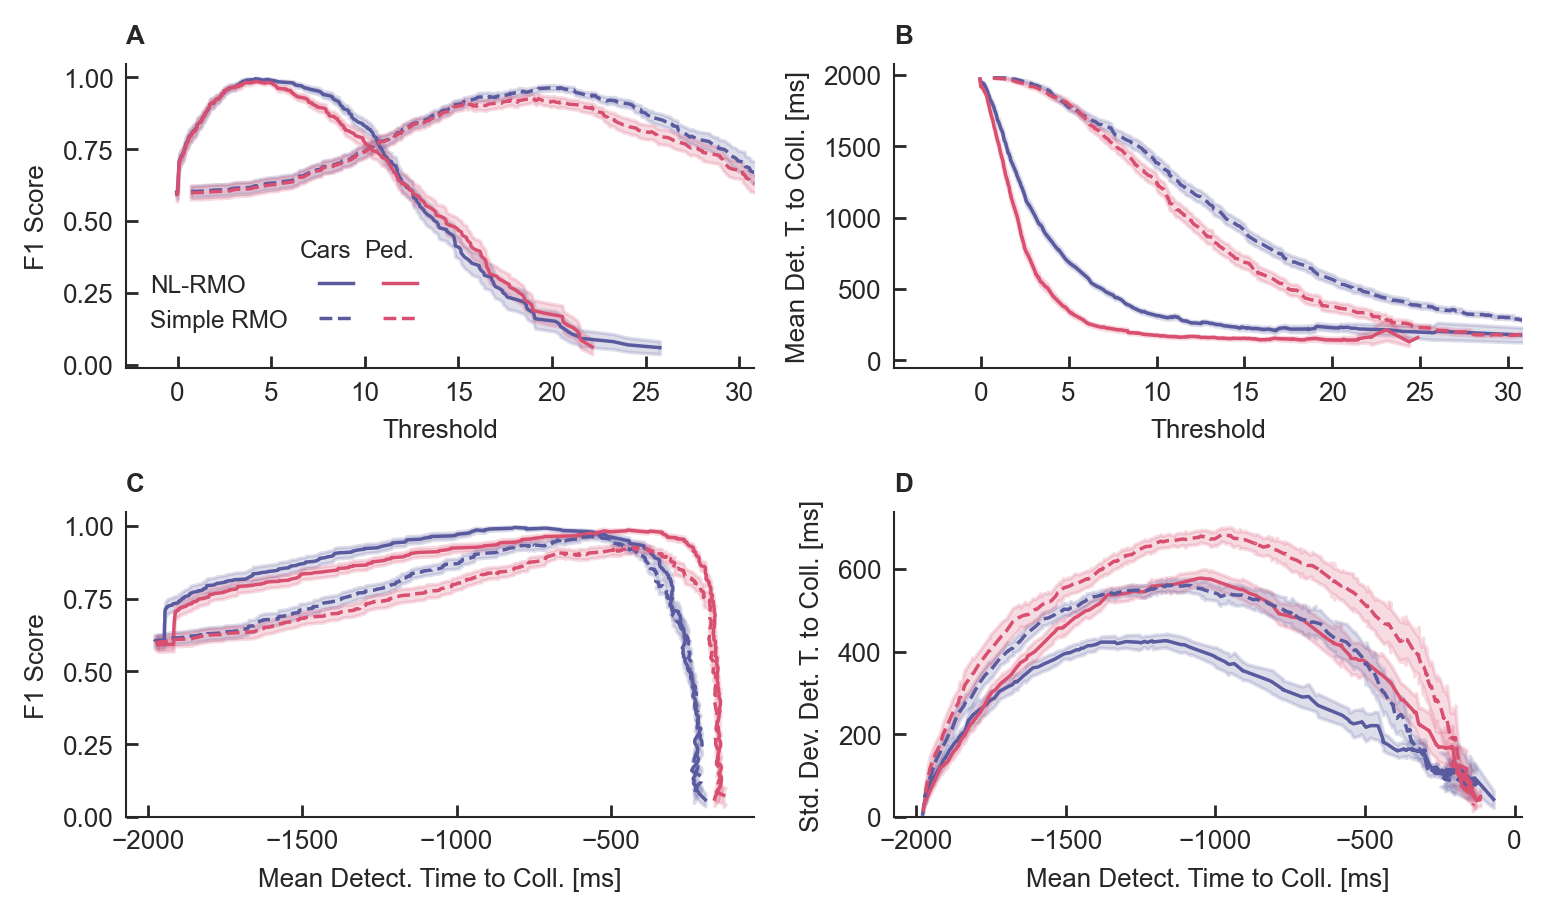

In [29]:
import matplotlib.patches as m_patches

plt.style.use('plots.mplstyle')
fig, _ax = plt.subplots(2, 2, figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.6))
ax = _ax.flatten()

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="NL-RMO"),
    m_patches.Patch(color="none", label="Simple RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]

ptch = [patches_column2, patches_column3]

for i, rmo in enumerate(["RMO", "No RMO"]):
    for j, obj in enumerate(["Cars", "Pedestrians"]):
        lnstyle = ["-", "--"][i]
        color = colors[j]

        (_line,) = ax[0].plot(th_range[rmo][obj], f1_mean[rmo][obj], lnstyle, c=color, label="*")

        ax[0].fill_between(
            th_range[rmo][obj],
            f1_mean[rmo][obj] - f1_sem[rmo][obj],
            f1_mean[rmo][obj] + f1_sem[rmo][obj],
            alpha=0.2,
            color=color,
        )      

        ax[1].plot(th_range[rmo][obj], mean_t_detect[rmo][obj], lnstyle, c=color)

        ax[1].fill_between(
            th_range[rmo][obj],
            mean_t_detect[rmo][obj] - sem_t_detect[rmo][obj],
            mean_t_detect[rmo][obj] + sem_t_detect[rmo][obj],
            alpha=0.2,
            color=color,
        )   

        ax[2].plot(-mean_t_detect[rmo][obj], f1_mean[rmo][obj], lnstyle, c=color)

        ax[2].fill_between(
            -mean_t_detect[rmo][obj],
            f1_mean[rmo][obj] - f1_sem[rmo][obj],
            f1_mean[rmo][obj] + f1_sem[rmo][obj],
            alpha=0.2,
            color=color,
        )

        ax[3].plot(-mean_t_detect[rmo][obj], std_t_detect[rmo][obj], lnstyle, c=color)

        ax[3].fill_between(
            -mean_t_detect[rmo][obj],
            std_t_detect[rmo][obj] - se_std_t_detect[rmo][obj],
            std_t_detect[rmo][obj] + se_std_t_detect[rmo][obj],
            alpha=0.2,
            color=color,
        )

        ptch[j].append(_line)


for _ax in ax[:2]: 
    _ax.set_xlim(right=30.8)
    _ax.set_xlabel("Threshold")

for _ax in ax[2:]:
    _ax.set_ylim(bottom=0.0)
    _ax.set_xlabel("Mean Detect. Time to Coll. [ms]")

for _ax in (ax[0], ax[2]):
    _ax.set_ylabel("F1 Score")

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")


#ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
#ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax[0].set_ylabel("F1 Score")
ax[1].set_ylabel("Mean Det. T. to Coll. [ms]")
ax[3].set_ylabel("Std. Dev. Det. T. to Coll. [ms]")

for i, letter in enumerate(["A", "B", "C", "D"]):
    ax[i].set_title(letter, loc="left", fontweight="bold")


fig.tight_layout()

fig.savefig("f1_score_detect_time_emd.png", dpi=300)
fig.savefig("f1_score_detect_time_emd.pdf", dpi=300)

plt.show()

In [10]:
def gen_evt_hist(evts: np.ndarray, t: float, dt: float, w: int, h: int) -> np.ndarray:
    evts_filt = evts[(evts["t"] >= t) & (evts["t"] < (t + dt))]

    hist = np.histogram2d(
        evts_filt["x"],
        evts_filt["y"],
        bins=[np.arange(w + 1), np.arange(h + 1)],
        weights=evts_filt["p"].astype("i1") * 2 - 1,
    )

    img = np.minimum(1.0, np.maximum(-1.0, hist[0].T))

    return img

In [11]:
data_car_passing = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_car_passing.npz"))

idx_start_passing = 100
idx_end = 250

V_passing = data_car_passing["V"][idx_start_passing:idx_end]
r_left_passing = data_car_passing["r_left"][idx_start_passing:idx_end]
r_right_passing = data_car_passing["r_right"][idx_start_passing:idx_end]
V_linear_passing = (r_left_passing + r_right_passing)

t_ms_passing = np.arange(0, len(V_passing)) * 10.0

events_passing = data_car_passing["events"]

data_right_turn = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_right_turn.npz"))

idx_start_turn = 75
idx_end = -1

V_turn = data_right_turn["V"][idx_start_turn:idx_end]
r_left_turn = data_right_turn["r_left"][idx_start_turn:idx_end]
r_right_turn = data_right_turn["r_right"][idx_start_turn:idx_end]
V_linear_turn = (r_left_turn + r_right_turn)

t_ms_turn = np.arange(0, len(V_turn)) * 10.0

events_turn = data_right_turn["events"]

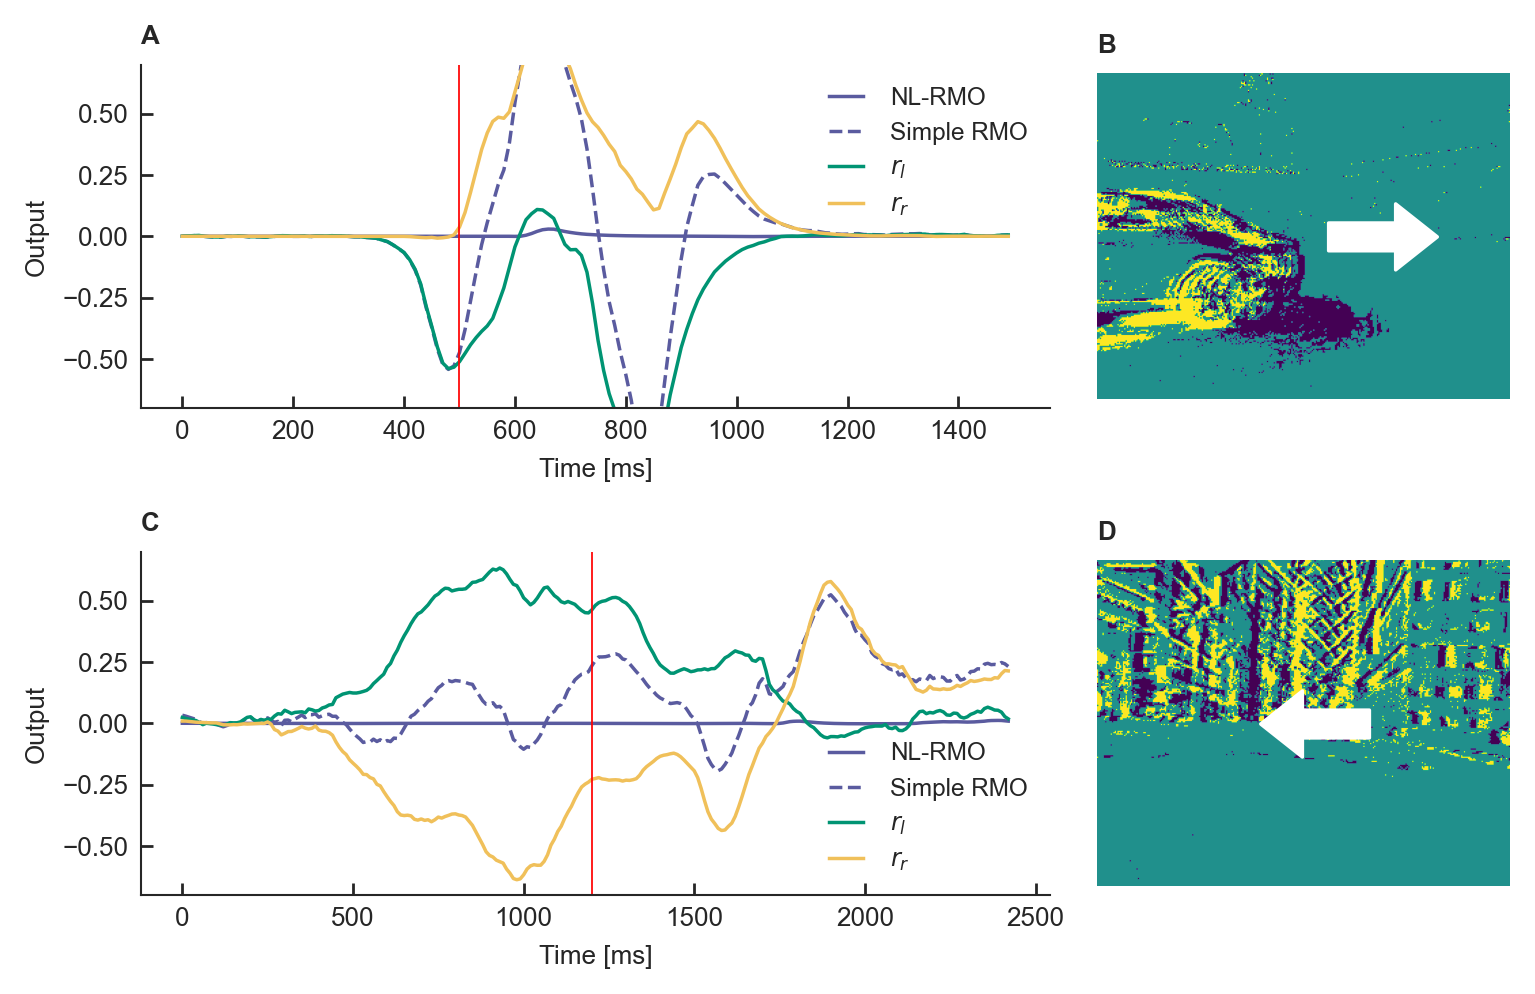

In [21]:
from matplotlib.colors import ListedColormap

#cmap_evts = ListedColormap([(1,0,0), "black", (0,1,0)])
cmap_evts = "viridis"

plt.style.use('plots.mplstyle')

fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.65))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

#w_l = 0.64
#w_r = 0.4
#m_l = 0.065
#m_r = 0.66
#m_b = 0.08
#m_t = 0.5 + m_b - 0.025
#h = 0.5 - m_b - 0.025
gs = fig.add_gridspec(2, 2, width_ratios=[2.2, 1], height_ratios=[1, 1])

ax = []
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[0, 1]))
ax.append(fig.add_subplot(gs[1, 0]))
ax.append(fig.add_subplot(gs[1, 1]))


#fig, ax = plt.subplots(1, 2, figsize=(13,5))

ax[0].plot(t_ms_passing, V_passing, label="NL-RMO", color=colors[0])
ax[0].plot(t_ms_passing, V_linear_passing, '--', label="Simple RMO", color=colors[0])
ax[0].plot(t_ms_passing, r_left_passing, label="$r_l$", color=colors[2])
ax[0].plot(t_ms_passing, r_right_passing, label="$r_r$", color=colors[3])

ax[0].legend()

ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Output")

ax[0].vlines([500], -0.7, 0.7, color="red", linestyle="-", linewidth=0.5)

ax[0].set_ylim(-0.7, 0.7)

img = gen_evt_hist(events_passing, 500 + 10*idx_start_passing, 50., 304, 240)

ax[1].imshow(img, cmap=cmap_evts, vmin=-1.0, vmax=1.0)
ax[1].grid(False)

ax[1].spines["left"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)

ax[1].set_xticks([])
ax[1].set_yticks([])

ax[1].annotate(None,xy=(250,120),xytext=(170,120),arrowprops={"width": 8, "headwidth": 19, "color": "white"})

ax[2].plot(t_ms_turn, V_turn, label="NL-RMO", color=colors[0])
ax[2].plot(t_ms_turn, V_linear_turn, '--', label="Simple RMO", color=colors[0])
ax[2].plot(t_ms_turn, r_left_turn, label="$r_l$", color=colors[2])
ax[2].plot(t_ms_turn, r_right_turn, label="$r_r$", color=colors[3])

ax[2].legend()

ax[2].set_xlabel("Time [ms]")
ax[2].set_ylabel("Output")

ax[2].vlines([1200], -0.7, 0.7, color="red", linestyle="-", linewidth=0.5)

ax[2].set_ylim(-0.7, 0.7)
img = gen_evt_hist(events_turn,1200 + 10*idx_start_turn, 50., 304, 240)

ax[3].imshow(img, cmap=cmap_evts, vmin=-1.0, vmax=1.0)
ax[3].grid(False)

ax[3].spines["left"].set_visible(False)
ax[3].spines["bottom"].set_visible(False)

ax[3].set_xticks([])
ax[3].set_yticks([])

ax[3].annotate(None,xy=(120,120),xytext=(200,120),arrowprops={"width": 8, "headwidth": 19, "color": "white"})

for i, c in enumerate("ABCD"):
    ax[i].set_title(c, loc="left", fontweight="bold")

fig.tight_layout()

#fig.tight_layout(pad=0.25)

fig.savefig("car_passing_turn.png", dpi=300)
fig.savefig("car_passing_turn.pdf", dpi=300)

plt.show()

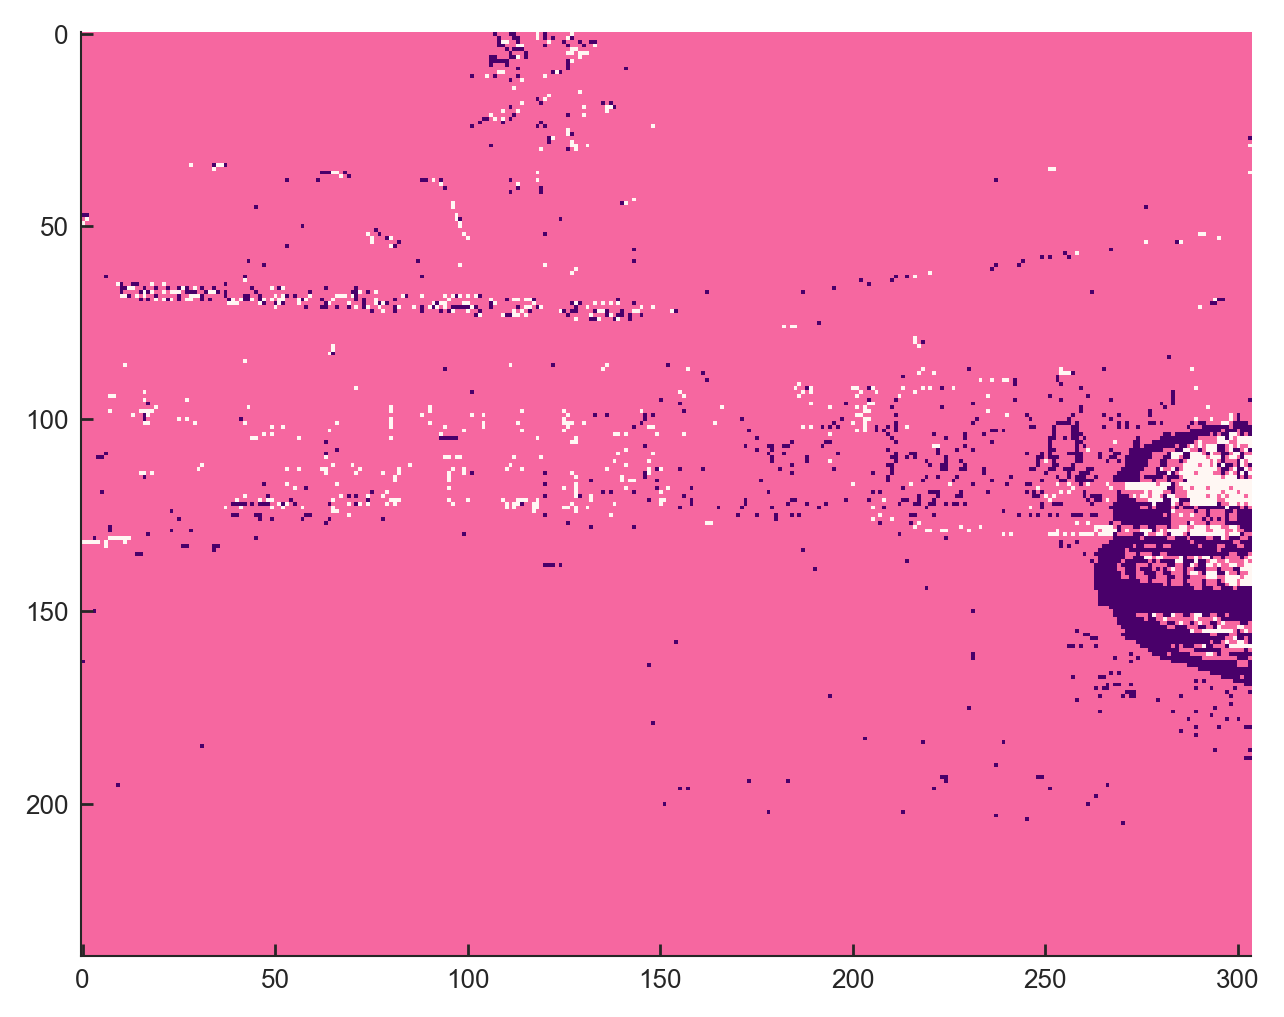

In [44]:
k = 540000

plt.imshow(gen_evt_hist(events_passing[k:k+10000], 0., 20., 304, 240))
plt.show()

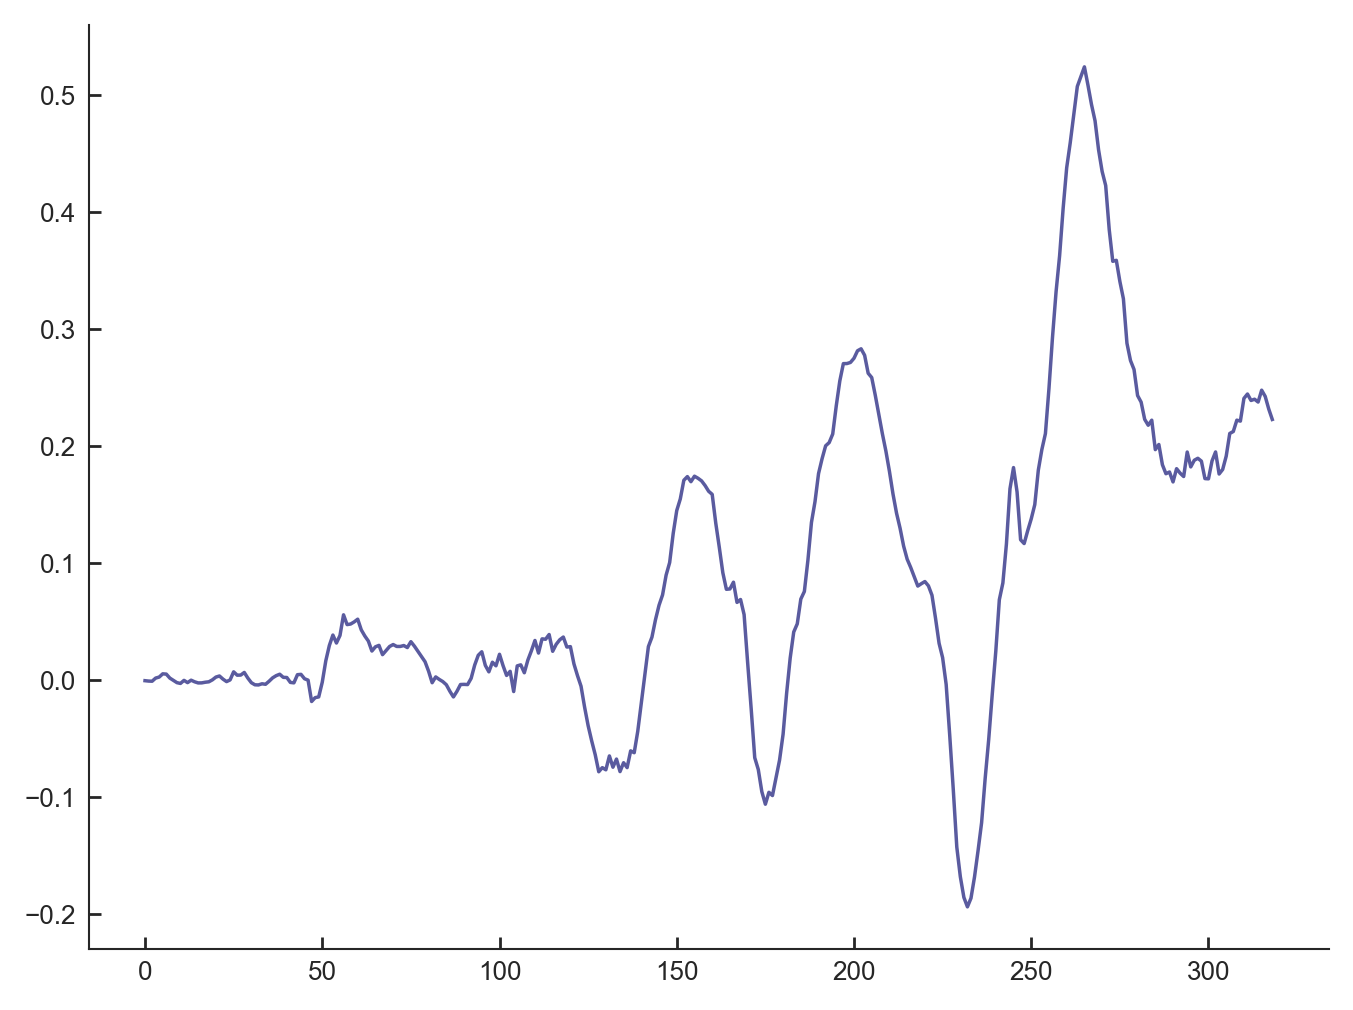

In [45]:
plt.plot(data_right_turn["r_left"]+data_right_turn["r_right"])
plt.show()

In [46]:
data_right_turn["V"].shape

(319,)

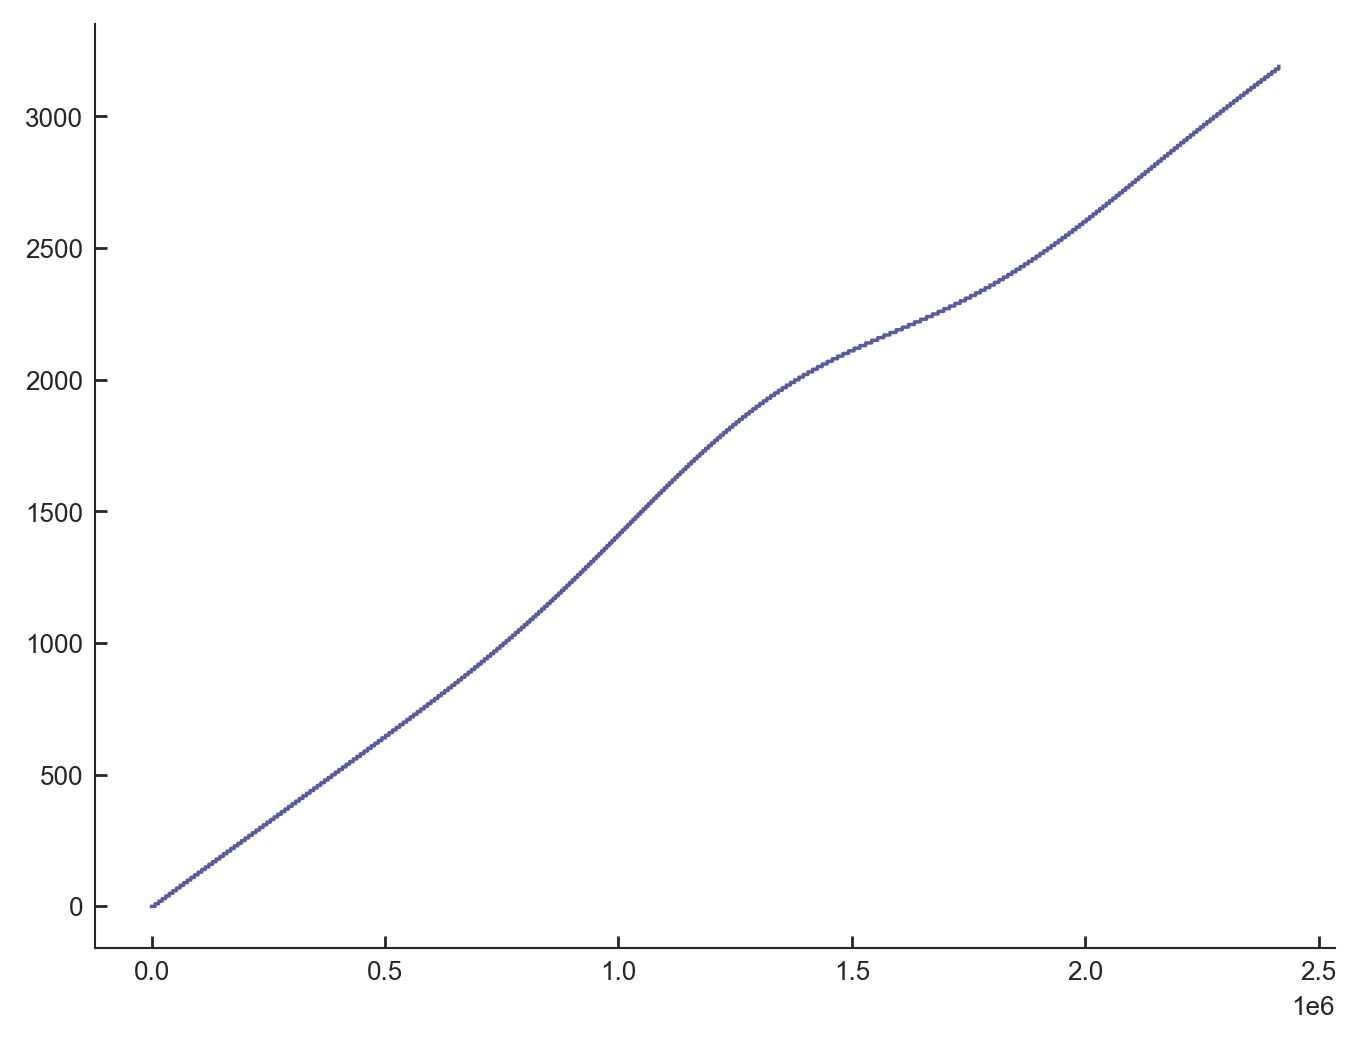

In [ ]:

rnd = np.random.rand(len(data_right_turn["events"]))
ftrnd = np.fft.fft(rnd)
ftrnd[3:] = 0
ftrnd[0] = 0
rnd = np.fft.ifft(ftrnd).real * 900000
rnd *= (np.cos((np.linspace(0.,1.,len(rnd))-0.5)*np.pi * 2)+1) * 0.5

t_ax = ((np.linspace(0, 3190, len(rnd)) + rnd) / 10).astype(int) * 10

plt.plot(t_ax)
plt.show()

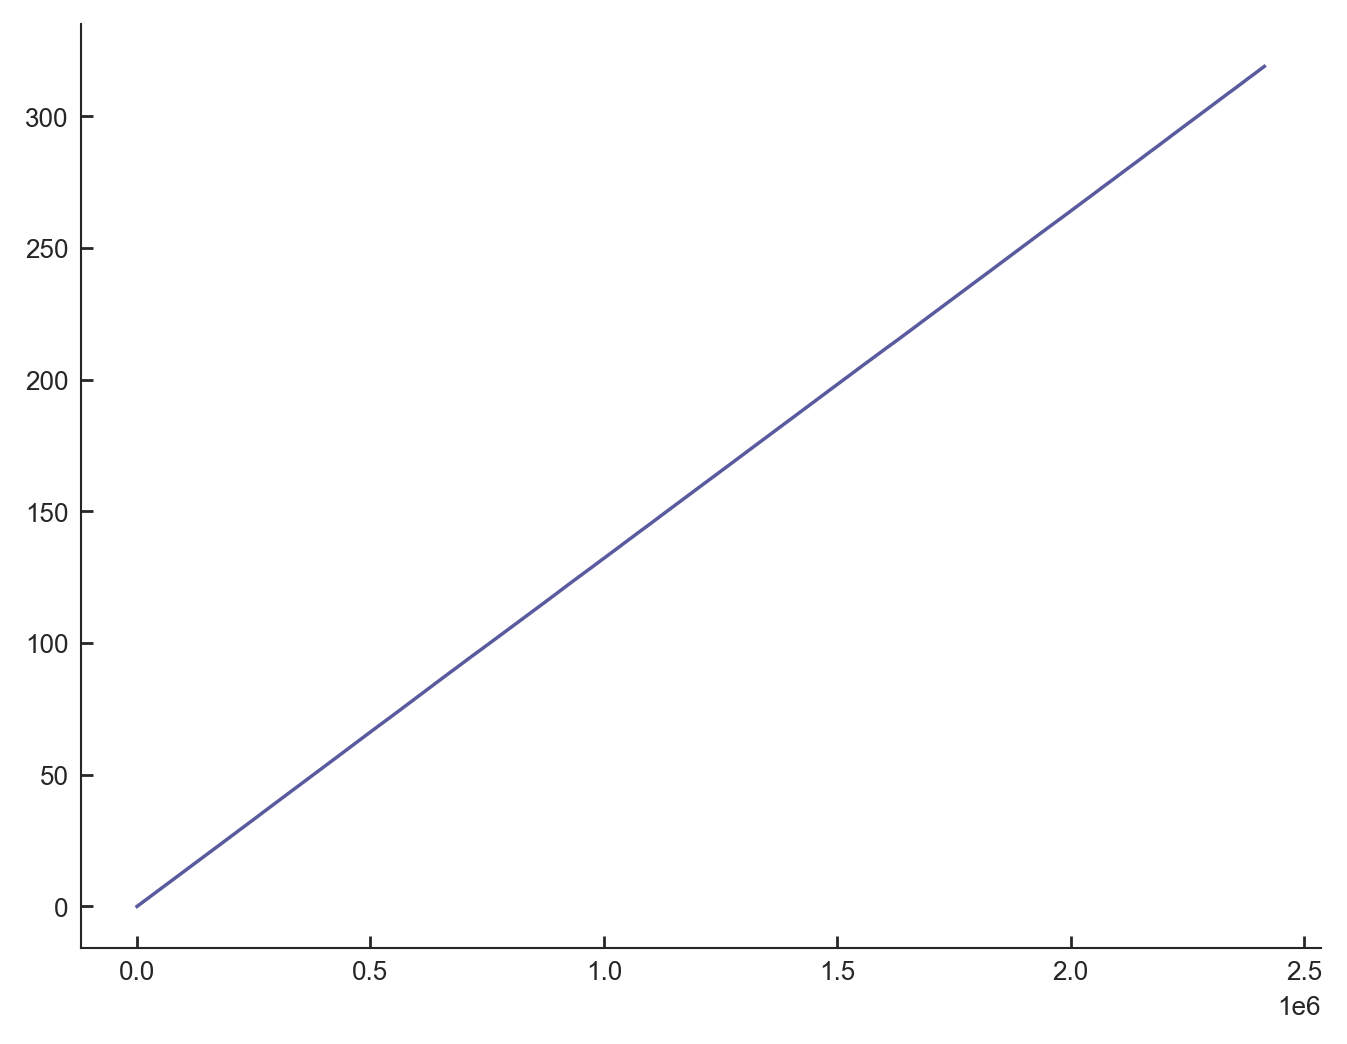

In [48]:
t_ax=np.random.rand(len(data_right_turn["events"])) * len(data_right_turn["V"])
t_ax = np.sort(t_ax)

plt.plot(t_ax)
plt.show()

In [50]:
events_example = np.load("../../../data/carla_sim/random_spawn/example_0/events.npy")

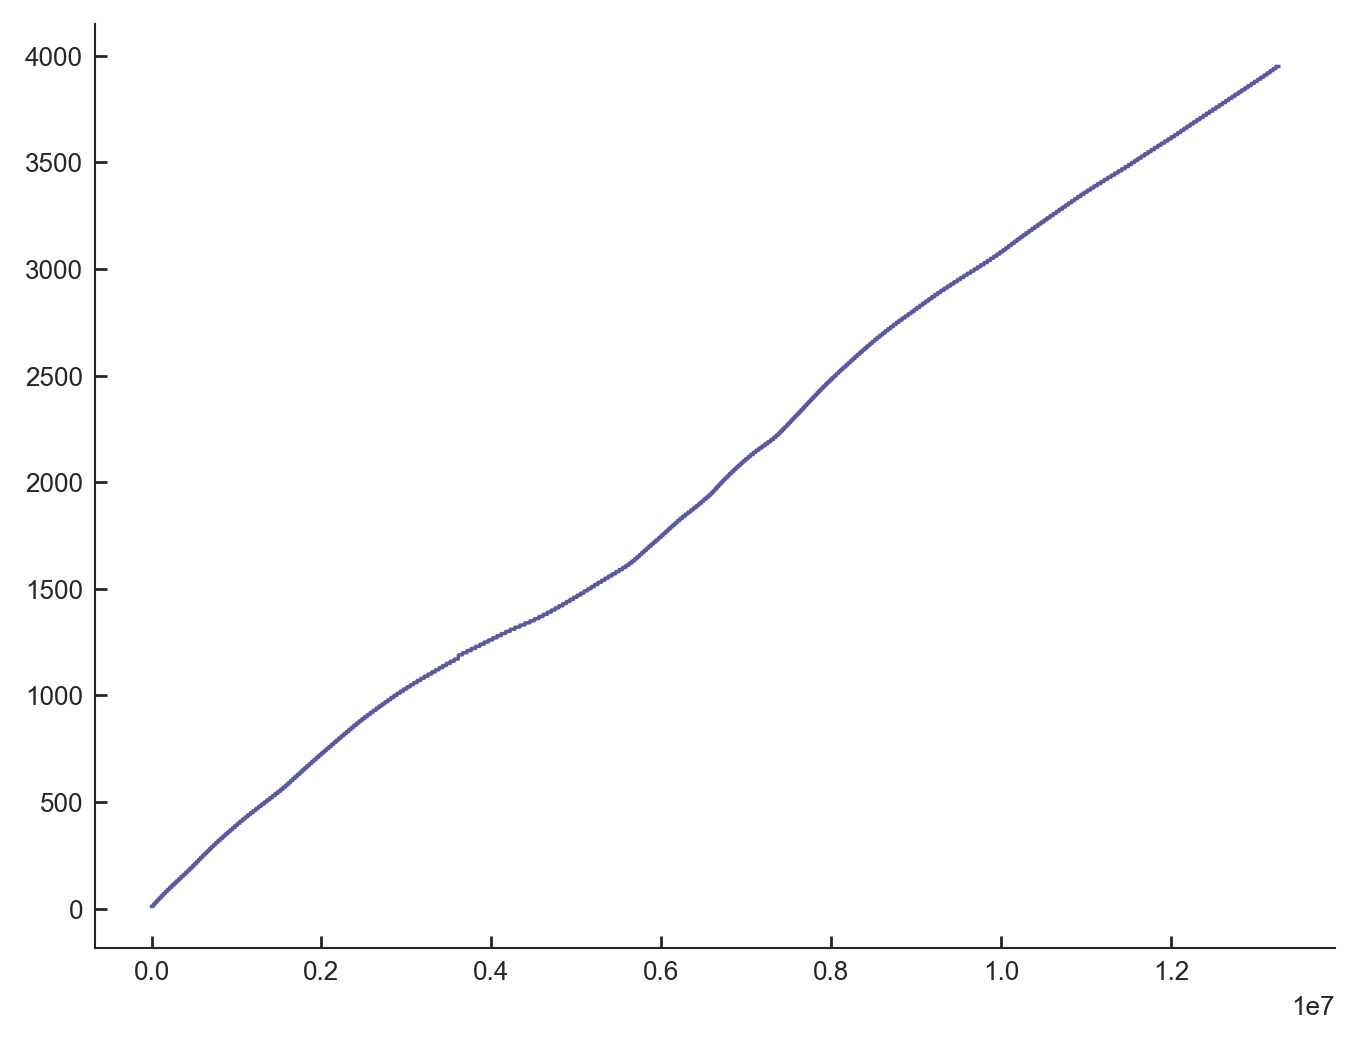

In [53]:
plt.plot(events_example["t"])
plt.show()

In [41]:
data_right_turn = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_right_turn.npz"))

idx_start = 75
idx_end = -1

V = data_right_turn["V"][idx_start:idx_end]
r_left = data_right_turn["r_left"][idx_start:idx_end]
r_right = data_right_turn["r_right"][idx_start:idx_end]
V_linear = 0.5 * (r_left + r_right)

t_ms = np.arange(0, len(V)) * 10.0

events = data_right_turn["events"]